Trains a grammar encoder to predict meta-scene-tree production params (grammars) on the 2D box grammar.

In [1]:
%load_ext autoreload
%autoreload 2    
# Autoreload isn't working for the ssg stuff,
# unclear why, I think it has too many layers of imports.

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.torch_utils import *
from spatial_scene_grammars.neural_grammar_proposal import *

from spatial_scene_grammars_examples.planar_box_stacks_complex.grammar import *

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/ipykernel_launcher.py:23: _DrakeImportWarning: 
You may have already (directly or indirectly) imported `torch` which uses
`RTLD_GLOBAL`. Using `RTLD_GLOBAL` may cause symbol collisions which manifest
themselves in bugs like "free(): invalid pointer". Please consider importing
`pydrake` (and related C++-wrapped libraries like `cv2`, `open3d`, etc.)
*before* importing `torch`. For more details, see:
https://github.com/pytorch/pytorch/issues/3059#issuecomment-534676459

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Unconditional grammar outputs look like this:

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


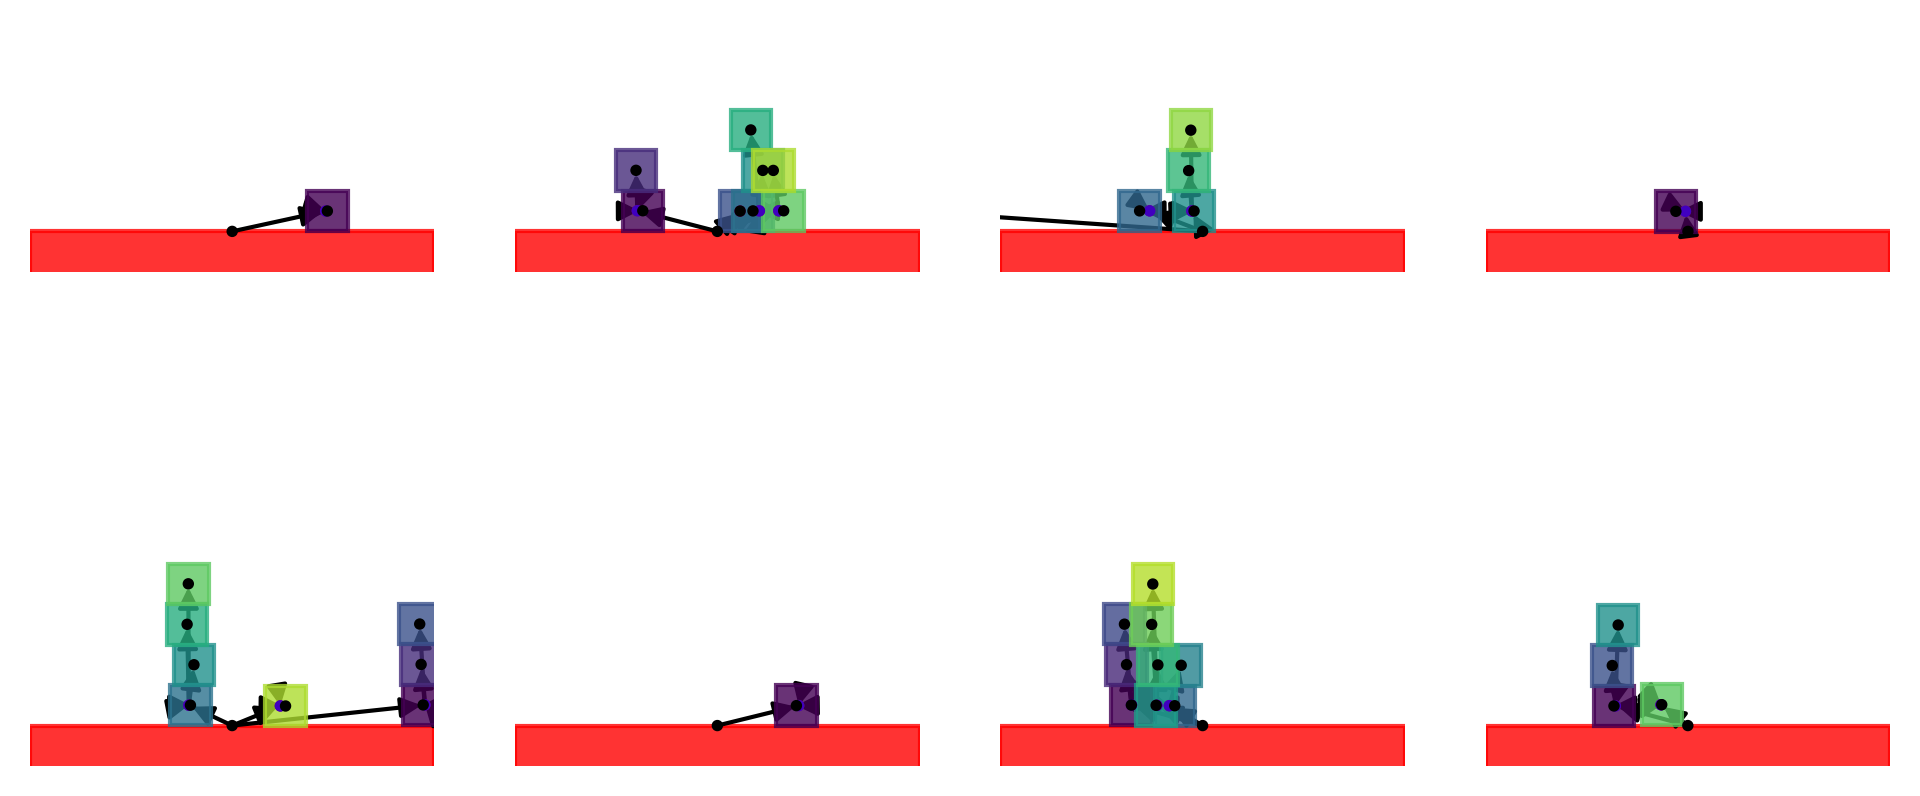

In [2]:
root_inst_dict = {"xy": dist.Normal(torch.tensor([0., 0.]), torch.tensor([0.001, 0.001]))}
grammar = SceneGrammar(Ground, root_inst_dict)
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        tree = grammar()
        draw_boxes(tree, fig=fig, ax=ax, block=False)
plt.show()

With an additional nonpenetration constraint, we rejection sample and no longer get penetrating configurations:

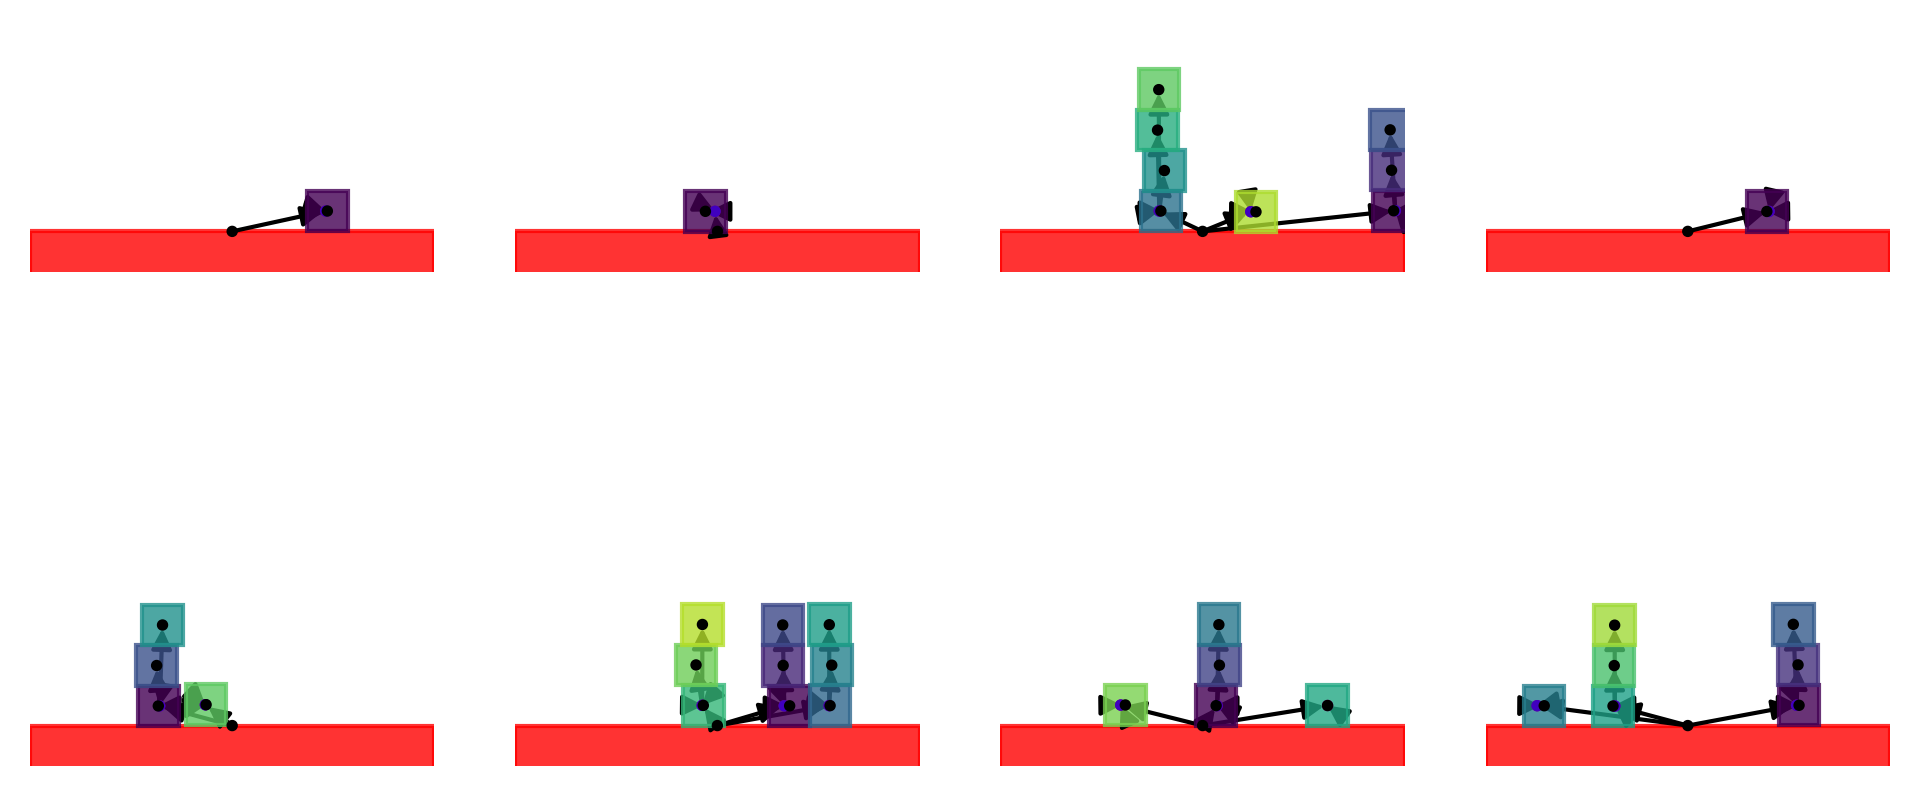

In [3]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
observed_full_trees = []
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            print("WARNING: SAMPLING UNSUCCESSFUL")
        draw_boxes(scene_trees[0], fig=fig, ax=ax, block=False)
        observed_full_trees.append(scene_trees[0])
plt.show()

In [4]:
trace = pyro.poutine.trace(grammar.forward).get_trace()
print(trace.nodes.keys())

odict_keys(['_INPUT', 'Ground_26_sample_derived/xy', 'Ground_26_choose_children/sample_children_inclusion', 'Group_66_sample_derived/xy', 'Group_66_choose_children/sample_children_inclusion', 'Stack_59_sample_derived/xy', 'Stack_59_choose_children/sample_children_inclusion', 'Box_130_sample_derived/xy', 'Box_131_sample_derived/xy', '_RETURN'])


The "meta" ("super"? "Hyper", as in hypergraph? still deciding terminology) scene tree is a tree containing all scene trees in the language -- any generated tree is a subtree of this tree. Here it is for this language. I'm wondering at the moment if it's the right structure to make reasoning about inference over the space of scene trees easier.


(340.46345, 978.2665499999999, -37.33605, 600.34605)

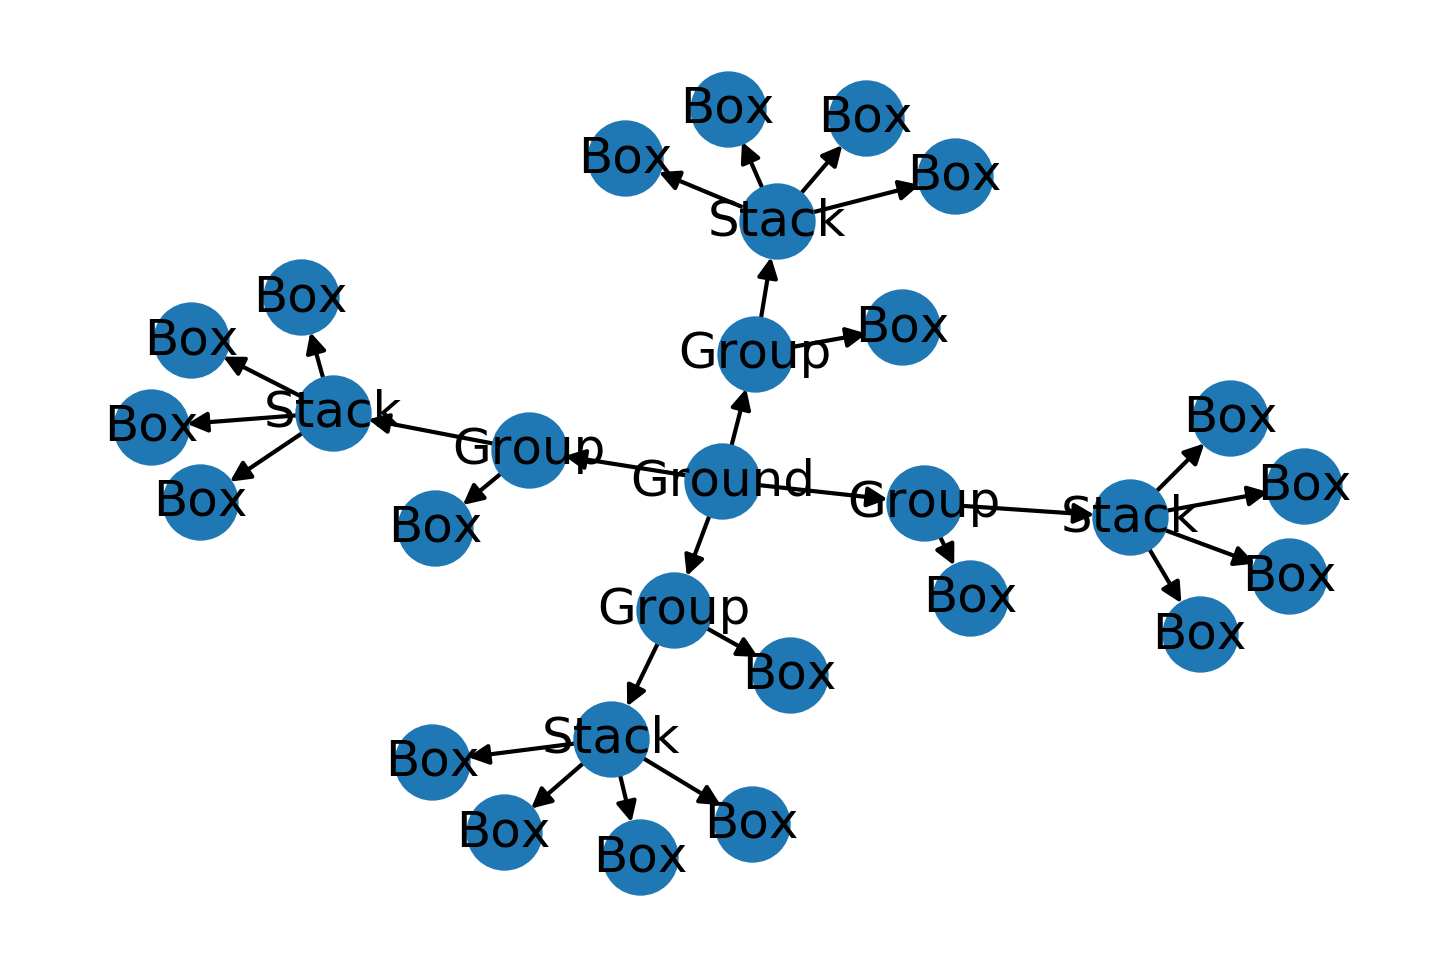

In [5]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300)
meta_tree = SceneGrammar.make_super_scene_tree(Ground)
ordering = nx.dfs_postorder_nodes(meta_tree, source=get_tree_root(meta_tree))
index_by_node = {node: k for (k, node) in enumerate(ordering)}
nx.draw_networkx(
    meta_tree,
    pos = graphviz_layout(meta_tree),
    labels={node: node.__class__.__name__ for node in meta_tree}
)
plt.axis("off")

So let's say we're given an observed set of boxes, and we'd like to think about what trees could have generated that observed set. There are two classes of strategy I'm thinking about:

1) "Top down" strategies (that try to grow trees from the root to meet the observed node set) might work, but will face scaling difficulties, and *precisely* meeting the observed nodes (and satisfying constraints) is going to be pretty tough.
2) "Bottom-up" strategies (that start from the observed node set, and parse out trees that satisfy the grammar and constraints) are more likely to be able to satisfy constraints, but they're more complex to write and turn into engines for inference, as they involve lots of ad-hoc construction.

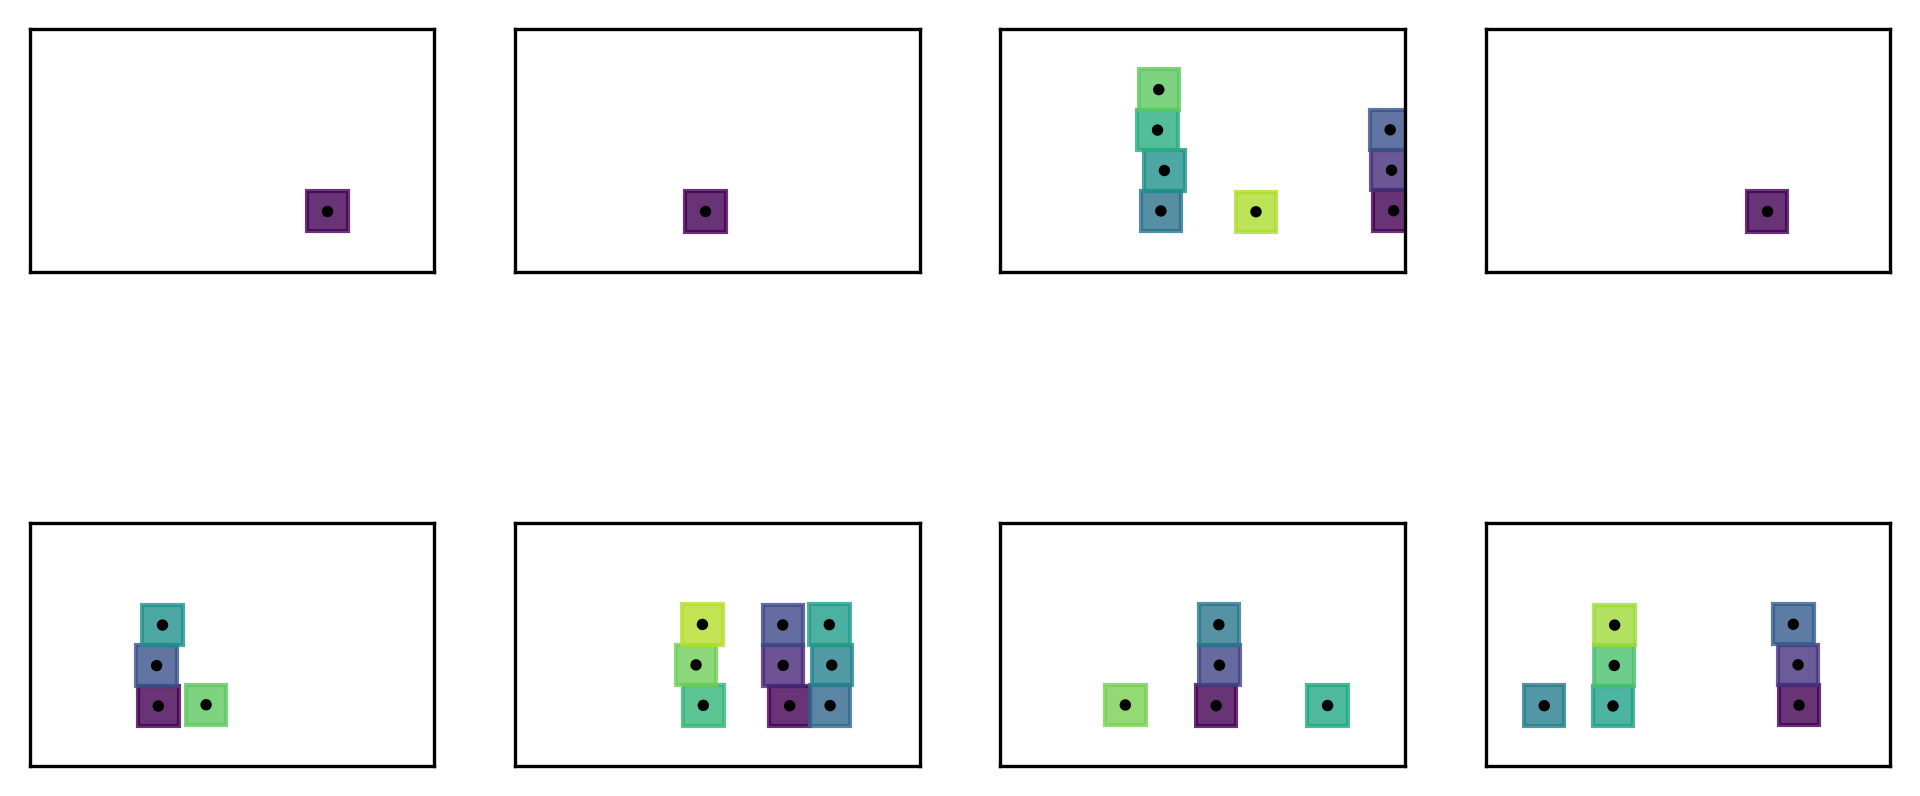

In [6]:
# Build observed trees
observed_trees = []
for tree in observed_full_trees:
    observed_tree = SceneTree()
    for node in tree:
        if isinstance(node, Box):
            observed_tree.add_node(node)
    observed_trees.append(observed_tree)

plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        k = i*N_height + j
        ax = plt.subplot(N_height, N_width, k + 1)
        draw_boxes(observed_trees[k], fig=fig, ax=ax, block=False)
        ax.axis("on")
plt.show()

## Neural grammar proposal generator on various grammars

Train an encoder to take a set of observed nodes and produce distributions over grammar parameters that are more likely to have generated those specific nodes.

##### Encoder

Exceedingly simple encoder: GRU iterations over (randomly reordered) fixed-size embeddings of each observed node, where the input is a fixed-size embedding and hidden state is the parameters of the distribution over parameters . Embeddings are generated by per-observed-node-type networks to transform variable-size node parameters into a fixed size parameter vector. 

#### Decoder and observation likelihood

A different scene grammar is a decoder: this could be the original grammar, or a different richer grammar that can generate everything the original grammar can. Given the inference grammar's parameters $z$, it induces a distribution over trees.

To train the whole system:
- Directly supervised: Given a full tree from the original grammar, the terminal nodes are encoded, and the inference grammar parameters is encouraged to be close to one that would generate the ground-truth full tree.
- Unsupervised: An observed node set is encoded. Grammars are sampled and trees forward-generated from them; each is scored against the observed node set using a supplied likelihood function. The embedding and encoder params are optimized with REINFORCE. I think that if the likelihood function ends up being an unbiased estimate of p(observed | grammar params) (perhaps by sampling trees and then computing p(observed | tree)), then this is exactly a VAE.

In [7]:
# Test out the observation likelihood.
observed_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
candidate_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
print(estimate_observation_likelihood(candidate_nodes, observed_nodes, 1./np.sqrt(2*np.pi)))

tensor([0.], grad_fn=<DivBackward0>)


In [8]:
# Make a bigger dataset of observed trees
full_trees_for_training = []
observed_nodes_for_training = []
def make_dataset(N=100):
    full_trees = []
    observed_nodes = []
    for k in range(N):
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            continue
        full_trees.append(scene_trees[0])
        observed_nodes.append([n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)])
    return full_trees, observed_nodes
full_trees_for_training, observed_nodes_for_training = make_dataset(400)
full_trees_for_testing, observed_nodes_for_testing = make_dataset(100)

In [9]:
# Try it out with an overparam'd form of the original grammar
inference_grammar = FullyParameterizedSuperTreeGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = FullyParameterizedGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = SceneGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
config = GrammarEncoder.Config(rnn_type="GRU")
encoder = GrammarEncoder(inference_grammar, 512, config=config)
x = encoder(observed_nodes_for_training[0])

if 0:
    # Load encoder from saved run.
    weight_path = "saved_models/20210602/encoder_supervised_-202.3508.torch"
    encoder.load_state_dict(torch.load(weight_path))
    encoder.eval()

Text(0.5, 0.98, 'Draws from encoder/decoder before any training, on TEST')

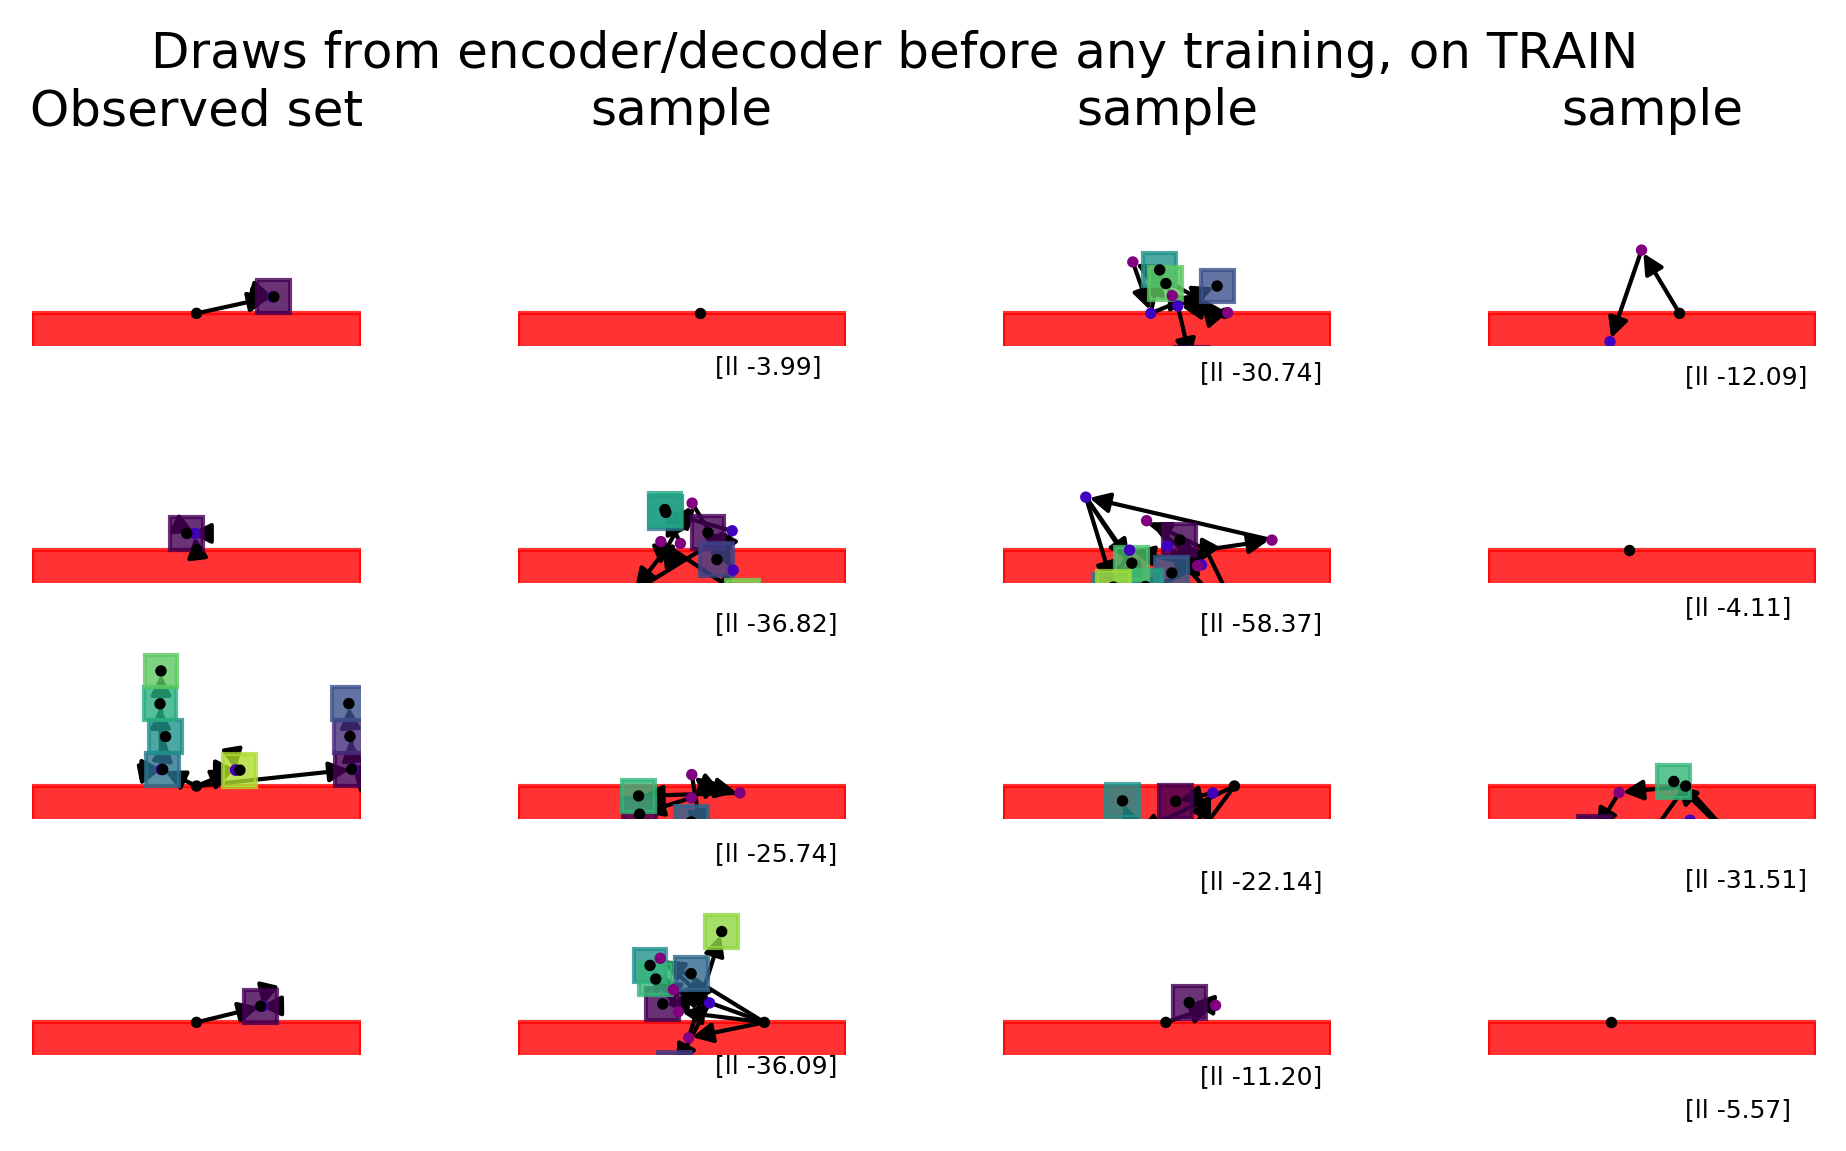

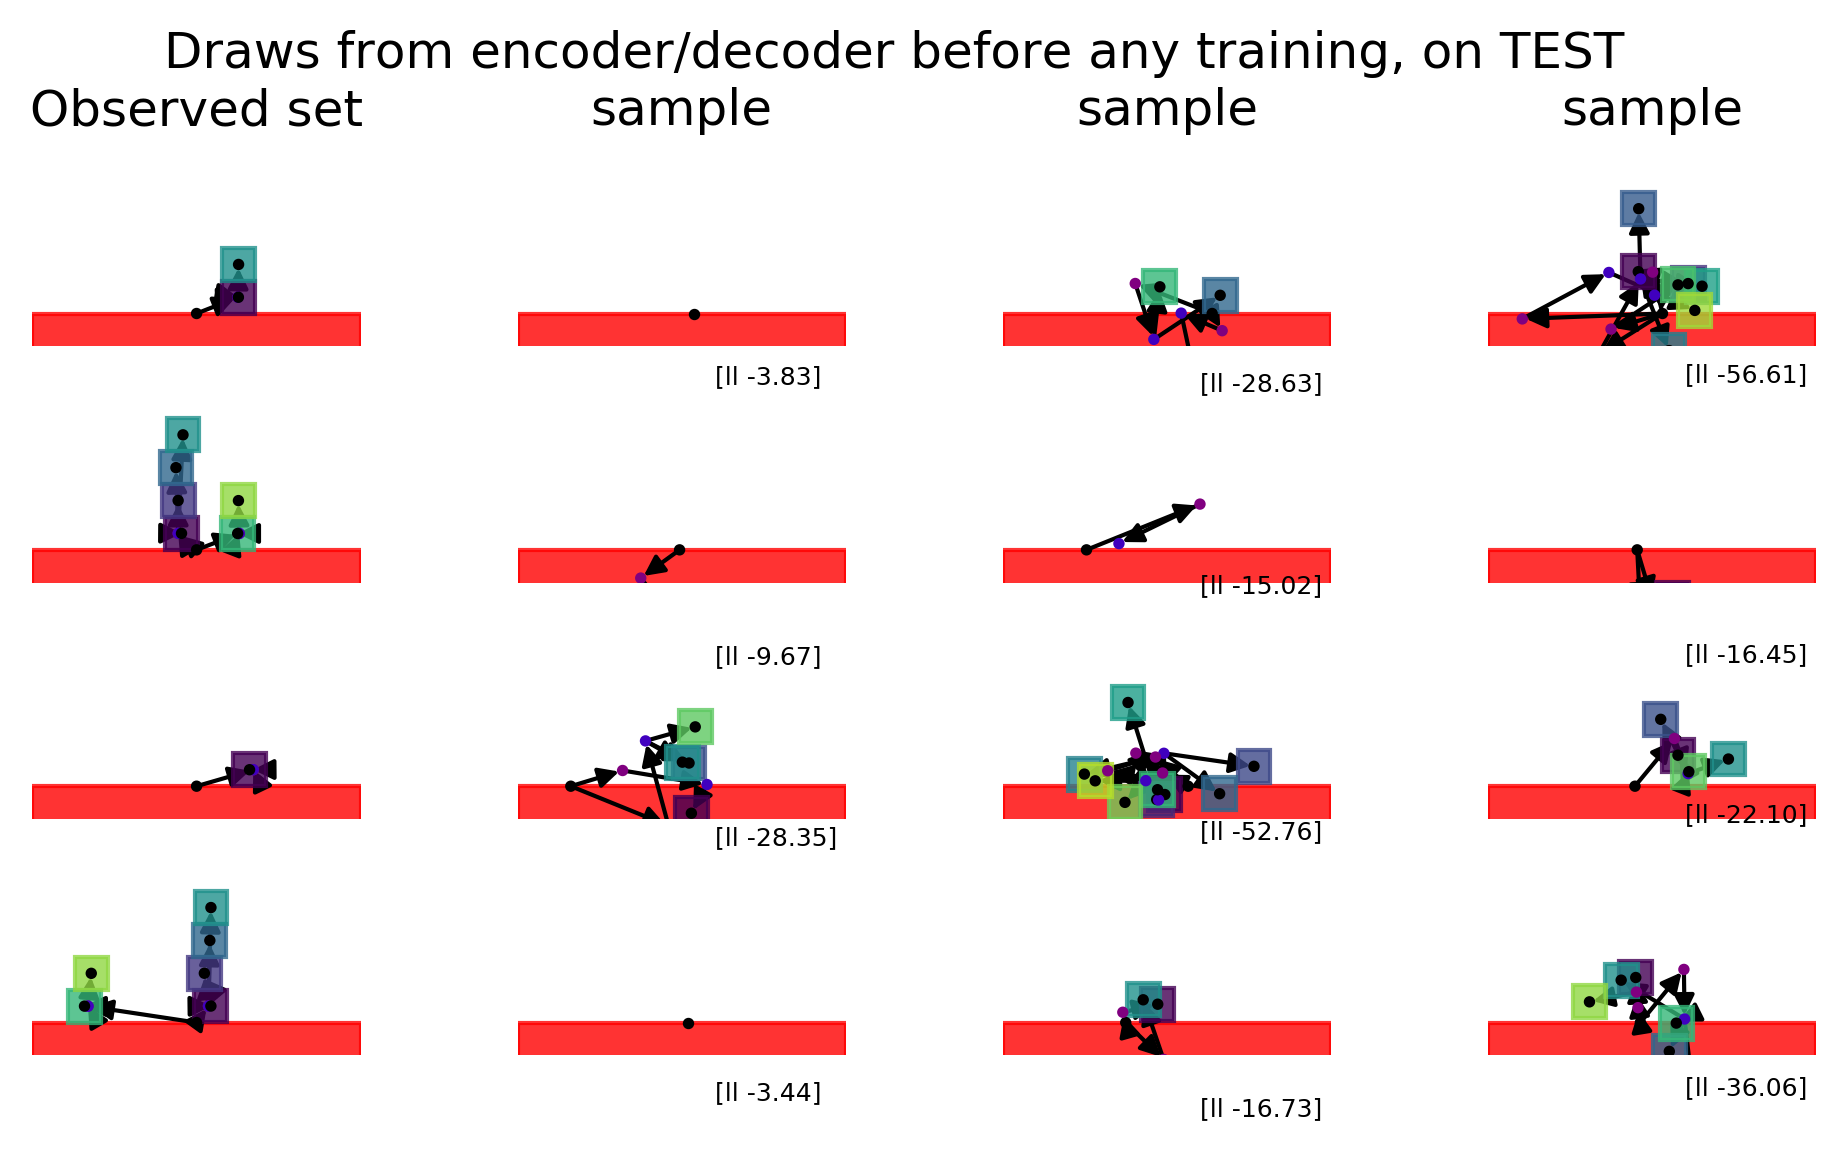

In [10]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(42)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder before any training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder before any training, on TEST")

0: 106.679649
100: -62.032345
200: -95.108849
300: -110.766685
400: -118.693542


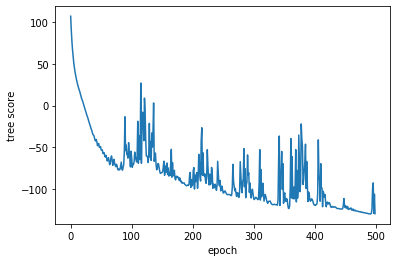

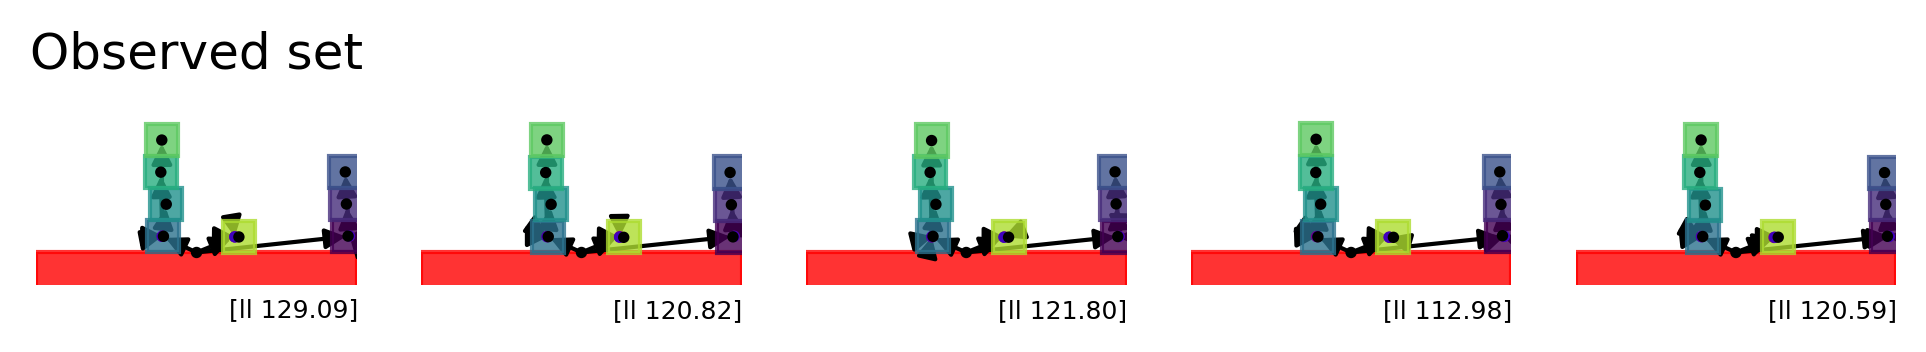

In [11]:
# Sanity-check grad descent: given a ground truth tree, can we
# recover the params of the auxiliary model that recover it?
full_tree = full_trees_for_training[2]
Nx = encoder.n_parameters
x = torch.normal(mean=torch.zeros(Nx), std=torch.ones(Nx)*0.1)
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=50, factor=0.5)
scores = []
for epoch in range(500):
    optimizer.zero_grad()
    score = -encoder.score_tree_with_grammar_vector(full_tree, x, detach=True)
    scores.append(score.detach().item())
    if epoch % 100 == 0:
        print("%d: %f" % (epoch, score))
    score.backward()
    optimizer.step()
    scheduler.step(score)
plt.plot(scores)
plt.xlabel("epoch")
plt.ylabel("tree score")
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 5
plt.subplot(1, N_width, 1)
draw_boxes(full_tree, fig=plt.gcf(), ax=plt.gca(), block=False)
plt.text(x=1., y=-2., s="[ll %0.2f]" % -score, fontsize=6)
plt.title("Observed set")
for k in range(N_width - 1):
    ax = plt.subplot(1, N_width, k + 2)
    plt.title("Sample %d" % k)
    sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
    draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
    plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

In [ ]:
# Sanity check a simpler auxiliary task: can the encoder spit out x s.t. the first element of x
# is the number of objects?
# Training
N_EPOCHS = 500
N_ITERS_PER_EPOCH = 10
CLIP_VALUE = 1E3
torch.manual_seed(1234)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=50, factor=0.5)

total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        total_objective += torch.mean(torch.square(x[0] - len(observed_nodes)))
    
    mean_objective = total_objective / N_ITERS_PER_EPOCH
    total_objective_history.append(mean_objective)
    if (epoch % 10 == 0):
        print("%d:Mean objective %.2f, lr %f"
              % (epoch, mean_objective, optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (mean_objective).backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)
    
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 10
plt.subplot(1, N_width, 1)
for k in range(N_width):
    ax = plt.subplot(1, N_width, k + 1)
    plt.title("Sample %d" % k)
    observed_nodes = observed_nodes_for_testing[k]
    x = encoder(observed_nodes)
    draw_boxes(full_trees_for_testing[k], fig=fig, ax=ax, block=False)
    plt.title("%0.1f" % x[0].item(), fontsize=6)

# Supervised [pre]training using full trees

This is for training the encoder to be in the neighborhood of being reasonable: given an observed tree, encode its observed nodes to get an inference grammar parameter set x, and then score the ground truth tree under that parameter set; backprob through x to increase the log-prob of the ground truth tree.

In [23]:
N_EPOCHS = 5000
N_ITERS_PER_EPOCH = 50
CHECKPOINT_SAVE_PERIOD=250
CLIP_VALUE = 1E3
torch.manual_seed(1234)

SETUP_TRAINING = False

def save_encoder_state(save_path):
    print("Saving to path ", save_path)
    try:
        dir_to_make = os.path.split(save_path)[0]
        if dir_to_make is not "":
            os.makedirs(dir_to_make)
    except FileExistsError:
        pass
    torch.save(encoder.state_dict(), save_path)
    print("Saved model to %s" % save_path)
    
checkpoint_save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime()),
    "checkpoints"
)

if SETUP_TRAINING:
    optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=250, factor=0.5)

    continuous_score_history = []
    discrete_score_history = []
    total_objective_history = []
    score_history = []
    all_gradients_history = {name: [] for name, _ in encoder.named_parameters()}
    epoch = 0

while epoch < N_EPOCHS:
    total_discrete_score = 0.
    total_continuous_score = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        
        full_tree = full_trees_for_training[iter_k]
        discrete_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=True,
            include_continuous=False
        )
        total_discrete_score += discrete_score
        continuous_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=False,
            include_continuous=True
        )
        total_continuous_score += continuous_score
    
    mean_discrete_score = total_discrete_score / N_ITERS_PER_EPOCH
    mean_continuous_score = total_continuous_score / N_ITERS_PER_EPOCH
    
    discrete_score_history.append(mean_discrete_score.detach())
    continuous_score_history.append(mean_continuous_score.detach())

    # Weight continuous factor to bring it to the same order of
    # magnitude as the discrete score.
    #avg_d = torch.tensor(discrete_score_history[-AVERAGE_WINDOW]).mean()
    #avg_c = torch.tensor(continuous_score_history[-AVERAGE_WINDOW]).mean()
    
    mean_objective = mean_discrete_score * 10. + mean_continuous_score
    total_objective_history.append(mean_objective)
    score_history.append(mean_objective)
    if (epoch % 1 == 0):
        print("%d:Mean objective %.2f, discrete %.2f, continuous %.2f, lr %f"
              % (epoch, mean_objective, mean_discrete_score, mean_continuous_score,
                 optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (-mean_objective).backward()
        # log gradients
        for name, param in encoder.named_parameters():
            if param.grad is None:
                all_gradients_history[name].append(torch.zeros(param.shape))
            else:
                all_gradients_history[name].append(deepcopy(param.grad.data))

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)
    
    if (epoch >= 0 and epoch % CHECKPOINT_SAVE_PERIOD == 0):
        save_encoder_state("saved_models/checkpoints/%d_%0.03f.torch" % (epoch, total_objective_history[-1]))

    epoch += 1

supervised_training_finish_time = time.time()

2058:Mean objective 20.40, discrete -0.28, continuous 23.15, lr 0.001000
2059:Mean objective 17.53, discrete -0.36, continuous 21.16, lr 0.001000
2060:Mean objective 17.70, discrete -0.32, continuous 20.90, lr 0.001000
2061:Mean objective 18.16, discrete -0.33, continuous 21.42, lr 0.001000
2062:Mean objective 17.61, discrete -0.34, continuous 21.01, lr 0.001000
2063:Mean objective 16.13, discrete -0.27, continuous 18.85, lr 0.001000
2064:Mean objective 17.17, discrete -0.33, continuous 20.50, lr 0.001000
2065:Mean objective 14.63, discrete -0.32, continuous 17.85, lr 0.001000
2066:Mean objective 18.40, discrete -0.28, continuous 21.23, lr 0.001000
2067:Mean objective 16.00, discrete -0.38, continuous 19.82, lr 0.001000
2068:Mean objective 19.16, discrete -0.36, continuous 22.75, lr 0.001000
2069:Mean objective 19.28, discrete -0.33, continuous 22.56, lr 0.001000
2070:Mean objective 16.91, discrete -0.44, continuous 21.30, lr 0.001000
2071:Mean objective 19.43, discrete -0.28, continuo

2171:Mean objective 17.00, discrete -0.31, continuous 20.11, lr 0.001000
2172:Mean objective 18.95, discrete -0.31, continuous 22.01, lr 0.001000
2173:Mean objective 18.73, discrete -0.28, continuous 21.52, lr 0.001000
2174:Mean objective 17.40, discrete -0.26, continuous 20.00, lr 0.001000
2175:Mean objective 15.25, discrete -0.35, continuous 18.71, lr 0.001000
2176:Mean objective 15.02, discrete -0.36, continuous 18.62, lr 0.001000
2177:Mean objective 17.86, discrete -0.25, continuous 20.34, lr 0.001000
2178:Mean objective 17.85, discrete -0.30, continuous 20.89, lr 0.001000
2179:Mean objective 17.10, discrete -0.36, continuous 20.74, lr 0.001000
2180:Mean objective 18.24, discrete -0.34, continuous 21.61, lr 0.001000
2181:Mean objective 19.84, discrete -0.25, continuous 22.35, lr 0.001000
2182:Mean objective 18.39, discrete -0.34, continuous 21.80, lr 0.001000
2183:Mean objective 17.91, discrete -0.34, continuous 21.36, lr 0.001000
2184:Mean objective 15.49, discrete -0.30, continuo

2282:Mean objective 17.29, discrete -0.34, continuous 20.72, lr 0.001000
2283:Mean objective 19.41, discrete -0.21, continuous 21.55, lr 0.001000
2284:Mean objective 18.43, discrete -0.29, continuous 21.31, lr 0.001000
2285:Mean objective 19.10, discrete -0.33, continuous 22.38, lr 0.001000
2286:Mean objective 20.70, discrete -0.26, continuous 23.34, lr 0.001000
2287:Mean objective 20.49, discrete -0.28, continuous 23.24, lr 0.001000
2288:Mean objective 17.42, discrete -0.26, continuous 20.03, lr 0.001000
2289:Mean objective 18.84, discrete -0.35, continuous 22.31, lr 0.001000
2290:Mean objective 18.30, discrete -0.31, continuous 21.39, lr 0.001000
2291:Mean objective 20.74, discrete -0.25, continuous 23.20, lr 0.001000
2292:Mean objective 23.00, discrete -0.21, continuous 25.11, lr 0.001000
2293:Mean objective 19.83, discrete -0.24, continuous 22.25, lr 0.001000
2294:Mean objective 17.88, discrete -0.30, continuous 20.88, lr 0.001000
2295:Mean objective 17.26, discrete -0.34, continuo

2395:Mean objective 18.98, discrete -0.22, continuous 21.18, lr 0.001000
2396:Mean objective 19.09, discrete -0.28, continuous 21.90, lr 0.001000
2397:Mean objective 19.10, discrete -0.21, continuous 21.19, lr 0.001000
2398:Mean objective 17.76, discrete -0.32, continuous 20.95, lr 0.001000
2399:Mean objective 17.68, discrete -0.37, continuous 21.35, lr 0.001000
2400:Mean objective 19.28, discrete -0.32, continuous 22.48, lr 0.001000
2401:Mean objective 16.06, discrete -0.34, continuous 19.48, lr 0.001000
2402:Mean objective 15.56, discrete -0.35, continuous 19.03, lr 0.001000
2403:Mean objective 18.68, discrete -0.21, continuous 20.81, lr 0.001000
2404:Mean objective 18.50, discrete -0.25, continuous 20.96, lr 0.001000
2405:Mean objective 19.79, discrete -0.23, continuous 22.07, lr 0.001000
2406:Mean objective 18.63, discrete -0.30, continuous 21.60, lr 0.001000
2407:Mean objective 17.81, discrete -0.28, continuous 20.59, lr 0.001000
2408:Mean objective 17.10, discrete -0.28, continuo

2506:Mean objective 23.76, discrete -0.33, continuous 27.02, lr 0.000500
2507:Mean objective 28.17, discrete -0.22, continuous 30.40, lr 0.000500
2508:Mean objective 24.87, discrete -0.32, continuous 28.05, lr 0.000500
2509:Mean objective 26.22, discrete -0.24, continuous 28.57, lr 0.000500
2510:Mean objective 25.70, discrete -0.27, continuous 28.39, lr 0.000500
2511:Mean objective 27.96, discrete -0.17, continuous 29.61, lr 0.000500
2512:Mean objective 24.07, discrete -0.26, continuous 26.70, lr 0.000500
2513:Mean objective 25.10, discrete -0.21, continuous 27.23, lr 0.000500
2514:Mean objective 28.77, discrete -0.14, continuous 30.18, lr 0.000500
2515:Mean objective 23.11, discrete -0.23, continuous 25.40, lr 0.000500
2516:Mean objective 22.65, discrete -0.32, continuous 25.82, lr 0.000500
2517:Mean objective 23.30, discrete -0.23, continuous 25.62, lr 0.000500
2518:Mean objective 27.10, discrete -0.24, continuous 29.47, lr 0.000500
2519:Mean objective 23.54, discrete -0.28, continuo

2619:Mean objective 24.23, discrete -0.28, continuous 27.05, lr 0.000500
2620:Mean objective 26.90, discrete -0.26, continuous 29.48, lr 0.000500
2621:Mean objective 27.13, discrete -0.28, continuous 29.89, lr 0.000500
2622:Mean objective 31.87, discrete -0.16, continuous 33.45, lr 0.000500
2623:Mean objective 27.19, discrete -0.27, continuous 29.85, lr 0.000500
2624:Mean objective 28.36, discrete -0.26, continuous 30.91, lr 0.000500
2625:Mean objective 28.10, discrete -0.24, continuous 30.54, lr 0.000500
2626:Mean objective 24.80, discrete -0.30, continuous 27.79, lr 0.000500
2627:Mean objective 26.73, discrete -0.24, continuous 29.14, lr 0.000500
2628:Mean objective 25.36, discrete -0.31, continuous 28.42, lr 0.000500
2629:Mean objective 31.87, discrete -0.18, continuous 33.64, lr 0.000500
2630:Mean objective 26.64, discrete -0.20, continuous 28.69, lr 0.000500
2631:Mean objective 31.00, discrete -0.21, continuous 33.09, lr 0.000500
2632:Mean objective 28.08, discrete -0.22, continuo

2732:Mean objective 27.28, discrete -0.28, continuous 30.07, lr 0.000500
2733:Mean objective 27.64, discrete -0.28, continuous 30.45, lr 0.000500
2734:Mean objective 28.46, discrete -0.22, continuous 30.65, lr 0.000500
2735:Mean objective 29.76, discrete -0.25, continuous 32.24, lr 0.000500
2736:Mean objective 29.41, discrete -0.25, continuous 31.90, lr 0.000500
2737:Mean objective 27.42, discrete -0.20, continuous 29.37, lr 0.000500
2738:Mean objective 26.75, discrete -0.24, continuous 29.13, lr 0.000500
2739:Mean objective 28.63, discrete -0.27, continuous 31.29, lr 0.000500
2740:Mean objective 24.31, discrete -0.26, continuous 26.87, lr 0.000500
2741:Mean objective 29.72, discrete -0.20, continuous 31.75, lr 0.000500
2742:Mean objective 25.01, discrete -0.34, continuous 28.37, lr 0.000500
2743:Mean objective 30.39, discrete -0.25, continuous 32.85, lr 0.000500
2744:Mean objective 28.03, discrete -0.29, continuous 30.90, lr 0.000500
2745:Mean objective 29.22, discrete -0.21, continuo

2843:Mean objective 30.17, discrete -0.19, continuous 32.03, lr 0.000500
2844:Mean objective 28.28, discrete -0.16, continuous 29.86, lr 0.000500
2845:Mean objective 27.70, discrete -0.22, continuous 29.87, lr 0.000500
2846:Mean objective 27.96, discrete -0.25, continuous 30.49, lr 0.000500
2847:Mean objective 24.92, discrete -0.31, continuous 28.06, lr 0.000500
2848:Mean objective 26.22, discrete -0.21, continuous 28.37, lr 0.000500
2849:Mean objective 28.71, discrete -0.22, continuous 30.93, lr 0.000500
2850:Mean objective 23.26, discrete -0.35, continuous 26.78, lr 0.000500
2851:Mean objective 26.86, discrete -0.29, continuous 29.80, lr 0.000500
2852:Mean objective 27.65, discrete -0.26, continuous 30.23, lr 0.000500
2853:Mean objective 27.73, discrete -0.30, continuous 30.72, lr 0.000500
2854:Mean objective 25.02, discrete -0.30, continuous 27.99, lr 0.000500
2855:Mean objective 29.62, discrete -0.19, continuous 31.47, lr 0.000500
2856:Mean objective 28.47, discrete -0.22, continuo

2956:Mean objective 27.30, discrete -0.21, continuous 29.38, lr 0.000500
2957:Mean objective 27.97, discrete -0.26, continuous 30.58, lr 0.000500
2958:Mean objective 26.15, discrete -0.25, continuous 28.63, lr 0.000500
2959:Mean objective 25.01, discrete -0.20, continuous 27.05, lr 0.000500
2960:Mean objective 27.48, discrete -0.19, continuous 29.41, lr 0.000500
2961:Mean objective 25.65, discrete -0.27, continuous 28.39, lr 0.000500
2962:Mean objective 24.37, discrete -0.29, continuous 27.23, lr 0.000500
2963:Mean objective 21.69, discrete -0.28, continuous 24.48, lr 0.000500
2964:Mean objective 23.14, discrete -0.25, continuous 25.66, lr 0.000500
2965:Mean objective 20.39, discrete -0.31, continuous 23.51, lr 0.000500
2966:Mean objective 22.90, discrete -0.31, continuous 26.05, lr 0.000500
2967:Mean objective 25.62, discrete -0.24, continuous 27.97, lr 0.000500
2968:Mean objective 26.74, discrete -0.23, continuous 29.00, lr 0.000500
2969:Mean objective 27.49, discrete -0.24, continuo

3067:Mean objective 32.28, discrete -0.29, continuous 35.18, lr 0.000250
3068:Mean objective 34.28, discrete -0.17, continuous 35.97, lr 0.000250
3069:Mean objective 31.81, discrete -0.25, continuous 34.35, lr 0.000250
3070:Mean objective 31.98, discrete -0.23, continuous 34.30, lr 0.000250
3071:Mean objective 34.15, discrete -0.23, continuous 36.45, lr 0.000250
3072:Mean objective 29.61, discrete -0.24, continuous 32.04, lr 0.000250
3073:Mean objective 32.77, discrete -0.23, continuous 35.08, lr 0.000250
3074:Mean objective 30.96, discrete -0.26, continuous 33.57, lr 0.000250
3075:Mean objective 33.89, discrete -0.20, continuous 35.91, lr 0.000250
3076:Mean objective 33.68, discrete -0.21, continuous 35.74, lr 0.000250
3077:Mean objective 30.90, discrete -0.27, continuous 33.64, lr 0.000250
3078:Mean objective 35.41, discrete -0.18, continuous 37.26, lr 0.000250
3079:Mean objective 36.16, discrete -0.18, continuous 38.00, lr 0.000250
3080:Mean objective 32.79, discrete -0.25, continuo

3180:Mean objective 34.86, discrete -0.23, continuous 37.20, lr 0.000250
3181:Mean objective 40.13, discrete -0.24, continuous 42.54, lr 0.000250
3182:Mean objective 36.89, discrete -0.20, continuous 38.88, lr 0.000250
3183:Mean objective 37.20, discrete -0.19, continuous 39.14, lr 0.000250
3184:Mean objective 35.16, discrete -0.17, continuous 36.87, lr 0.000250
3185:Mean objective 31.13, discrete -0.23, continuous 33.45, lr 0.000250
3186:Mean objective 36.52, discrete -0.21, continuous 38.64, lr 0.000250
3187:Mean objective 36.38, discrete -0.19, continuous 38.28, lr 0.000250
3188:Mean objective 35.12, discrete -0.20, continuous 37.12, lr 0.000250
3189:Mean objective 33.93, discrete -0.22, continuous 36.17, lr 0.000250
3190:Mean objective 37.51, discrete -0.19, continuous 39.37, lr 0.000250
3191:Mean objective 37.61, discrete -0.23, continuous 39.94, lr 0.000250
3192:Mean objective 34.85, discrete -0.18, continuous 36.67, lr 0.000250
3193:Mean objective 32.34, discrete -0.28, continuo

3291:Mean objective 32.47, discrete -0.29, continuous 35.36, lr 0.000250
3292:Mean objective 31.87, discrete -0.20, continuous 33.87, lr 0.000250
3293:Mean objective 35.01, discrete -0.23, continuous 37.28, lr 0.000250
3294:Mean objective 36.37, discrete -0.21, continuous 38.42, lr 0.000250
3295:Mean objective 33.16, discrete -0.21, continuous 35.30, lr 0.000250
3296:Mean objective 36.29, discrete -0.13, continuous 37.59, lr 0.000250
3297:Mean objective 34.61, discrete -0.18, continuous 36.41, lr 0.000250
3298:Mean objective 33.57, discrete -0.26, continuous 36.16, lr 0.000250
3299:Mean objective 36.83, discrete -0.17, continuous 38.56, lr 0.000250
3300:Mean objective 33.65, discrete -0.22, continuous 35.81, lr 0.000250
3301:Mean objective 34.56, discrete -0.21, continuous 36.68, lr 0.000250
3302:Mean objective 32.49, discrete -0.23, continuous 34.83, lr 0.000250
3303:Mean objective 36.25, discrete -0.17, continuous 37.94, lr 0.000250
3304:Mean objective 31.91, discrete -0.25, continuo

3404:Mean objective 36.56, discrete -0.25, continuous 39.09, lr 0.000250
3405:Mean objective 37.26, discrete -0.26, continuous 39.90, lr 0.000250
3406:Mean objective 36.58, discrete -0.19, continuous 38.45, lr 0.000250
3407:Mean objective 35.32, discrete -0.15, continuous 36.84, lr 0.000250
3408:Mean objective 35.99, discrete -0.26, continuous 38.54, lr 0.000250
3409:Mean objective 31.89, discrete -0.22, continuous 34.08, lr 0.000250
3410:Mean objective 37.50, discrete -0.19, continuous 39.36, lr 0.000250
3411:Mean objective 33.99, discrete -0.24, continuous 36.38, lr 0.000250
3412:Mean objective 34.21, discrete -0.23, continuous 36.50, lr 0.000250
3413:Mean objective 35.92, discrete -0.25, continuous 38.44, lr 0.000250
3414:Mean objective 37.99, discrete -0.26, continuous 40.59, lr 0.000250
3415:Mean objective 33.63, discrete -0.17, continuous 35.30, lr 0.000250
3416:Mean objective 35.41, discrete -0.16, continuous 36.98, lr 0.000250
3417:Mean objective 32.91, discrete -0.26, continuo

3515:Mean objective 37.05, discrete -0.21, continuous 39.19, lr 0.000125
3516:Mean objective 39.18, discrete -0.22, continuous 41.39, lr 0.000125
3517:Mean objective 37.38, discrete -0.25, continuous 39.84, lr 0.000125
3518:Mean objective 37.98, discrete -0.18, continuous 39.79, lr 0.000125
3519:Mean objective 38.59, discrete -0.22, continuous 40.78, lr 0.000125
3520:Mean objective 42.65, discrete -0.13, continuous 43.97, lr 0.000125
3521:Mean objective 39.93, discrete -0.22, continuous 42.17, lr 0.000125
3522:Mean objective 35.43, discrete -0.27, continuous 38.15, lr 0.000125
3523:Mean objective 34.52, discrete -0.25, continuous 37.07, lr 0.000125
3524:Mean objective 36.19, discrete -0.28, continuous 38.96, lr 0.000125
3525:Mean objective 39.30, discrete -0.18, continuous 41.12, lr 0.000125
3526:Mean objective 29.26, discrete -0.34, continuous 32.66, lr 0.000125
3527:Mean objective 37.16, discrete -0.21, continuous 39.27, lr 0.000125
3528:Mean objective 39.76, discrete -0.17, continuo

3628:Mean objective 38.25, discrete -0.19, continuous 40.13, lr 0.000125
3629:Mean objective 40.52, discrete -0.27, continuous 43.26, lr 0.000125
3630:Mean objective 39.72, discrete -0.22, continuous 41.94, lr 0.000125
3631:Mean objective 39.91, discrete -0.24, continuous 42.30, lr 0.000125
3632:Mean objective 44.54, discrete -0.20, continuous 46.57, lr 0.000125
3633:Mean objective 44.11, discrete -0.15, continuous 45.62, lr 0.000125
3634:Mean objective 37.94, discrete -0.25, continuous 40.48, lr 0.000125
3635:Mean objective 37.81, discrete -0.22, continuous 39.97, lr 0.000125
3636:Mean objective 40.56, discrete -0.16, continuous 42.17, lr 0.000125
3637:Mean objective 35.15, discrete -0.29, continuous 38.09, lr 0.000125
3638:Mean objective 43.74, discrete -0.21, continuous 45.85, lr 0.000125
3639:Mean objective 40.64, discrete -0.18, continuous 42.44, lr 0.000125
3640:Mean objective 41.13, discrete -0.27, continuous 43.82, lr 0.000125
3641:Mean objective 41.49, discrete -0.24, continuo

3741:Mean objective 41.74, discrete -0.20, continuous 43.76, lr 0.000125
3742:Mean objective 38.48, discrete -0.24, continuous 40.84, lr 0.000125
3743:Mean objective 39.73, discrete -0.24, continuous 42.11, lr 0.000125
3744:Mean objective 42.98, discrete -0.23, continuous 45.28, lr 0.000125
3745:Mean objective 42.80, discrete -0.24, continuous 45.17, lr 0.000125
3746:Mean objective 43.09, discrete -0.20, continuous 45.12, lr 0.000125
3747:Mean objective 38.92, discrete -0.21, continuous 41.01, lr 0.000125
3748:Mean objective 37.02, discrete -0.22, continuous 39.25, lr 0.000125
3749:Mean objective 35.91, discrete -0.17, continuous 37.64, lr 0.000125
3750:Mean objective 38.82, discrete -0.25, continuous 41.30, lr 0.000125
Saving to path  saved_models/checkpoints/3750_38.819.torch
Saved model to saved_models/checkpoints/3750_38.819.torch
3751:Mean objective 39.52, discrete -0.27, continuous 42.23, lr 0.000125
3752:Mean objective 40.40, discrete -0.14, continuous 41.77, lr 0.000125
3753:Me

3852:Mean objective 40.06, discrete -0.27, continuous 42.72, lr 0.000125
3853:Mean objective 43.92, discrete -0.19, continuous 45.83, lr 0.000125
3854:Mean objective 40.40, discrete -0.29, continuous 43.29, lr 0.000125
3855:Mean objective 40.37, discrete -0.24, continuous 42.80, lr 0.000125
3856:Mean objective 34.66, discrete -0.26, continuous 37.22, lr 0.000125
3857:Mean objective 41.08, discrete -0.26, continuous 43.66, lr 0.000125
3858:Mean objective 36.84, discrete -0.29, continuous 39.77, lr 0.000125
3859:Mean objective 38.43, discrete -0.25, continuous 40.91, lr 0.000125
3860:Mean objective 41.23, discrete -0.18, continuous 42.98, lr 0.000125
3861:Mean objective 40.10, discrete -0.20, continuous 42.07, lr 0.000063
3862:Mean objective 35.96, discrete -0.16, continuous 37.60, lr 0.000063
3863:Mean objective 41.70, discrete -0.26, continuous 44.25, lr 0.000063
3864:Mean objective 38.60, discrete -0.22, continuous 40.84, lr 0.000063
3865:Mean objective 41.63, discrete -0.22, continuo

3965:Mean objective 41.61, discrete -0.23, continuous 43.95, lr 0.000063
3966:Mean objective 40.95, discrete -0.24, continuous 43.37, lr 0.000063
3967:Mean objective 48.11, discrete -0.16, continuous 49.71, lr 0.000063
3968:Mean objective 40.55, discrete -0.25, continuous 43.07, lr 0.000063
3969:Mean objective 43.99, discrete -0.19, continuous 45.86, lr 0.000063
3970:Mean objective 39.44, discrete -0.26, continuous 42.05, lr 0.000063
3971:Mean objective 44.09, discrete -0.20, continuous 46.10, lr 0.000063
3972:Mean objective 39.23, discrete -0.26, continuous 41.80, lr 0.000063
3973:Mean objective 40.77, discrete -0.19, continuous 42.64, lr 0.000063
3974:Mean objective 43.57, discrete -0.20, continuous 45.61, lr 0.000063
3975:Mean objective 38.62, discrete -0.29, continuous 41.55, lr 0.000063
3976:Mean objective 43.95, discrete -0.17, continuous 45.63, lr 0.000063
3977:Mean objective 40.75, discrete -0.26, continuous 43.31, lr 0.000063
3978:Mean objective 40.11, discrete -0.26, continuo

4076:Mean objective 41.65, discrete -0.28, continuous 44.45, lr 0.000063
4077:Mean objective 41.19, discrete -0.18, continuous 42.98, lr 0.000063
4078:Mean objective 45.48, discrete -0.20, continuous 47.45, lr 0.000063
4079:Mean objective 42.48, discrete -0.23, continuous 44.75, lr 0.000063
4080:Mean objective 45.28, discrete -0.17, continuous 46.98, lr 0.000063
4081:Mean objective 51.75, discrete -0.19, continuous 53.66, lr 0.000063
4082:Mean objective 38.33, discrete -0.23, continuous 40.66, lr 0.000063
4083:Mean objective 39.02, discrete -0.29, continuous 41.93, lr 0.000063
4084:Mean objective 45.54, discrete -0.17, continuous 47.25, lr 0.000063
4085:Mean objective 42.14, discrete -0.26, continuous 44.77, lr 0.000063
4086:Mean objective 38.67, discrete -0.25, continuous 41.18, lr 0.000063
4087:Mean objective 40.20, discrete -0.25, continuous 42.68, lr 0.000063
4088:Mean objective 39.16, discrete -0.29, continuous 42.08, lr 0.000063
4089:Mean objective 44.02, discrete -0.15, continuo

4189:Mean objective 38.75, discrete -0.26, continuous 41.33, lr 0.000063
4190:Mean objective 44.03, discrete -0.21, continuous 46.15, lr 0.000063
4191:Mean objective 43.11, discrete -0.22, continuous 45.31, lr 0.000063
4192:Mean objective 46.16, discrete -0.35, continuous 49.63, lr 0.000063
4193:Mean objective 40.32, discrete -0.21, continuous 42.44, lr 0.000063
4194:Mean objective 48.58, discrete -0.18, continuous 50.38, lr 0.000063
4195:Mean objective 41.37, discrete -0.26, continuous 44.00, lr 0.000063
4196:Mean objective 42.94, discrete -0.24, continuous 45.36, lr 0.000063
4197:Mean objective 50.12, discrete -0.13, continuous 51.37, lr 0.000063
4198:Mean objective 41.95, discrete -0.25, continuous 44.48, lr 0.000063
4199:Mean objective 44.83, discrete -0.20, continuous 46.79, lr 0.000063
4200:Mean objective 41.46, discrete -0.29, continuous 44.40, lr 0.000063
4201:Mean objective 44.01, discrete -0.23, continuous 46.28, lr 0.000063
4202:Mean objective 40.04, discrete -0.26, continuo

4300:Mean objective 42.39, discrete -0.24, continuous 44.82, lr 0.000063
4301:Mean objective 36.89, discrete -0.33, continuous 40.21, lr 0.000063
4302:Mean objective 41.81, discrete -0.22, continuous 44.02, lr 0.000063
4303:Mean objective 46.56, discrete -0.25, continuous 49.05, lr 0.000063
4304:Mean objective 41.32, discrete -0.25, continuous 43.78, lr 0.000063
4305:Mean objective 39.46, discrete -0.25, continuous 41.98, lr 0.000063
4306:Mean objective 46.83, discrete -0.21, continuous 48.98, lr 0.000063
4307:Mean objective 36.88, discrete -0.32, continuous 40.12, lr 0.000063
4308:Mean objective 41.06, discrete -0.17, continuous 42.72, lr 0.000063
4309:Mean objective 50.57, discrete -0.17, continuous 52.26, lr 0.000063
4310:Mean objective 44.43, discrete -0.26, continuous 47.01, lr 0.000063
4311:Mean objective 42.30, discrete -0.23, continuous 44.58, lr 0.000063
4312:Mean objective 48.88, discrete -0.20, continuous 50.91, lr 0.000063
4313:Mean objective 44.18, discrete -0.27, continuo

4413:Mean objective 42.14, discrete -0.24, continuous 44.54, lr 0.000063
4414:Mean objective 47.90, discrete -0.22, continuous 50.07, lr 0.000063
4415:Mean objective 45.78, discrete -0.24, continuous 48.18, lr 0.000063
4416:Mean objective 41.82, discrete -0.33, continuous 45.08, lr 0.000063
4417:Mean objective 40.81, discrete -0.29, continuous 43.73, lr 0.000063
4418:Mean objective 40.87, discrete -0.29, continuous 43.76, lr 0.000063
4419:Mean objective 42.99, discrete -0.26, continuous 45.54, lr 0.000063
4420:Mean objective 45.22, discrete -0.22, continuous 47.40, lr 0.000063
4421:Mean objective 47.07, discrete -0.21, continuous 49.18, lr 0.000063
4422:Mean objective 47.56, discrete -0.21, continuous 49.71, lr 0.000063
4423:Mean objective 39.11, discrete -0.26, continuous 41.71, lr 0.000063
4424:Mean objective 42.36, discrete -0.21, continuous 44.48, lr 0.000063
4425:Mean objective 39.83, discrete -0.22, continuous 42.07, lr 0.000063
4426:Mean objective 41.22, discrete -0.23, continuo

4524:Mean objective 42.06, discrete -0.28, continuous 44.90, lr 0.000063
4525:Mean objective 38.41, discrete -0.19, continuous 40.35, lr 0.000063
4526:Mean objective 39.05, discrete -0.18, continuous 40.80, lr 0.000063
4527:Mean objective 41.53, discrete -0.26, continuous 44.17, lr 0.000063
4528:Mean objective 42.91, discrete -0.26, continuous 45.47, lr 0.000063
4529:Mean objective 43.95, discrete -0.20, continuous 46.00, lr 0.000063
4530:Mean objective 47.94, discrete -0.17, continuous 49.64, lr 0.000063
4531:Mean objective 47.36, discrete -0.20, continuous 49.38, lr 0.000063
4532:Mean objective 40.48, discrete -0.21, continuous 42.56, lr 0.000063
4533:Mean objective 45.71, discrete -0.26, continuous 48.30, lr 0.000063
4534:Mean objective 45.61, discrete -0.20, continuous 47.58, lr 0.000063
4535:Mean objective 42.19, discrete -0.32, continuous 45.41, lr 0.000063
4536:Mean objective 45.45, discrete -0.16, continuous 47.03, lr 0.000063
4537:Mean objective 46.30, discrete -0.19, continuo

4637:Mean objective 47.06, discrete -0.21, continuous 49.14, lr 0.000031
4638:Mean objective 47.93, discrete -0.23, continuous 50.20, lr 0.000031
4639:Mean objective 45.55, discrete -0.25, continuous 48.08, lr 0.000031
4640:Mean objective 47.34, discrete -0.22, continuous 49.54, lr 0.000031
4641:Mean objective 45.57, discrete -0.20, continuous 47.56, lr 0.000031
4642:Mean objective 45.02, discrete -0.22, continuous 47.17, lr 0.000031
4643:Mean objective 43.79, discrete -0.22, continuous 46.03, lr 0.000031
4644:Mean objective 43.43, discrete -0.23, continuous 45.77, lr 0.000031
4645:Mean objective 40.50, discrete -0.29, continuous 43.35, lr 0.000031
4646:Mean objective 51.12, discrete -0.23, continuous 53.40, lr 0.000031
4647:Mean objective 50.99, discrete -0.18, continuous 52.82, lr 0.000031
4648:Mean objective 46.19, discrete -0.21, continuous 48.32, lr 0.000031
4649:Mean objective 46.02, discrete -0.24, continuous 48.46, lr 0.000031
4650:Mean objective 49.56, discrete -0.22, continuo

4750:Mean objective 47.97, discrete -0.19, continuous 49.89, lr 0.000031
Saving to path  saved_models/checkpoints/4750_47.973.torch
Saved model to saved_models/checkpoints/4750_47.973.torch
4751:Mean objective 51.13, discrete -0.25, continuous 53.66, lr 0.000031
4752:Mean objective 49.35, discrete -0.19, continuous 51.26, lr 0.000031
4753:Mean objective 54.86, discrete -0.18, continuous 56.68, lr 0.000031
4754:Mean objective 51.43, discrete -0.23, continuous 53.71, lr 0.000031
4755:Mean objective 43.34, discrete -0.19, continuous 45.27, lr 0.000031
4756:Mean objective 42.80, discrete -0.24, continuous 45.16, lr 0.000031
4757:Mean objective 46.63, discrete -0.29, continuous 49.53, lr 0.000031
4758:Mean objective 39.70, discrete -0.34, continuous 43.09, lr 0.000031
4759:Mean objective 49.95, discrete -0.21, continuous 52.08, lr 0.000031
4760:Mean objective 47.37, discrete -0.31, continuous 50.52, lr 0.000031
4761:Mean objective 48.32, discrete -0.22, continuous 50.54, lr 0.000031
4762:Me

4861:Mean objective 50.36, discrete -0.20, continuous 52.40, lr 0.000031
4862:Mean objective 42.62, discrete -0.18, continuous 44.38, lr 0.000031
4863:Mean objective 46.35, discrete -0.22, continuous 48.58, lr 0.000031
4864:Mean objective 51.43, discrete -0.17, continuous 53.12, lr 0.000031
4865:Mean objective 42.84, discrete -0.20, continuous 44.83, lr 0.000031
4866:Mean objective 46.45, discrete -0.25, continuous 48.96, lr 0.000031
4867:Mean objective 45.43, discrete -0.19, continuous 47.37, lr 0.000031
4868:Mean objective 46.04, discrete -0.23, continuous 48.31, lr 0.000031
4869:Mean objective 39.49, discrete -0.22, continuous 41.73, lr 0.000031
4870:Mean objective 40.51, discrete -0.30, continuous 43.52, lr 0.000031
4871:Mean objective 43.10, discrete -0.25, continuous 45.63, lr 0.000031
4872:Mean objective 42.18, discrete -0.28, continuous 44.94, lr 0.000031
4873:Mean objective 44.68, discrete -0.22, continuous 46.88, lr 0.000031
4874:Mean objective 43.65, discrete -0.22, continuo

4974:Mean objective 50.23, discrete -0.26, continuous 52.86, lr 0.000016
4975:Mean objective 47.52, discrete -0.22, continuous 49.69, lr 0.000016
4976:Mean objective 48.01, discrete -0.23, continuous 50.27, lr 0.000016
4977:Mean objective 50.41, discrete -0.24, continuous 52.85, lr 0.000016
4978:Mean objective 48.94, discrete -0.23, continuous 51.24, lr 0.000016
4979:Mean objective 45.97, discrete -0.27, continuous 48.67, lr 0.000016
4980:Mean objective 42.36, discrete -0.20, continuous 44.35, lr 0.000016
4981:Mean objective 48.55, discrete -0.28, continuous 51.32, lr 0.000016
4982:Mean objective 50.71, discrete -0.23, continuous 52.99, lr 0.000016
4983:Mean objective 46.88, discrete -0.21, continuous 48.98, lr 0.000016
4984:Mean objective 43.11, discrete -0.20, continuous 45.10, lr 0.000016
4985:Mean objective 44.43, discrete -0.31, continuous 47.50, lr 0.000016
4986:Mean objective 46.67, discrete -0.26, continuous 49.31, lr 0.000016
4987:Mean objective 47.50, discrete -0.17, continuo

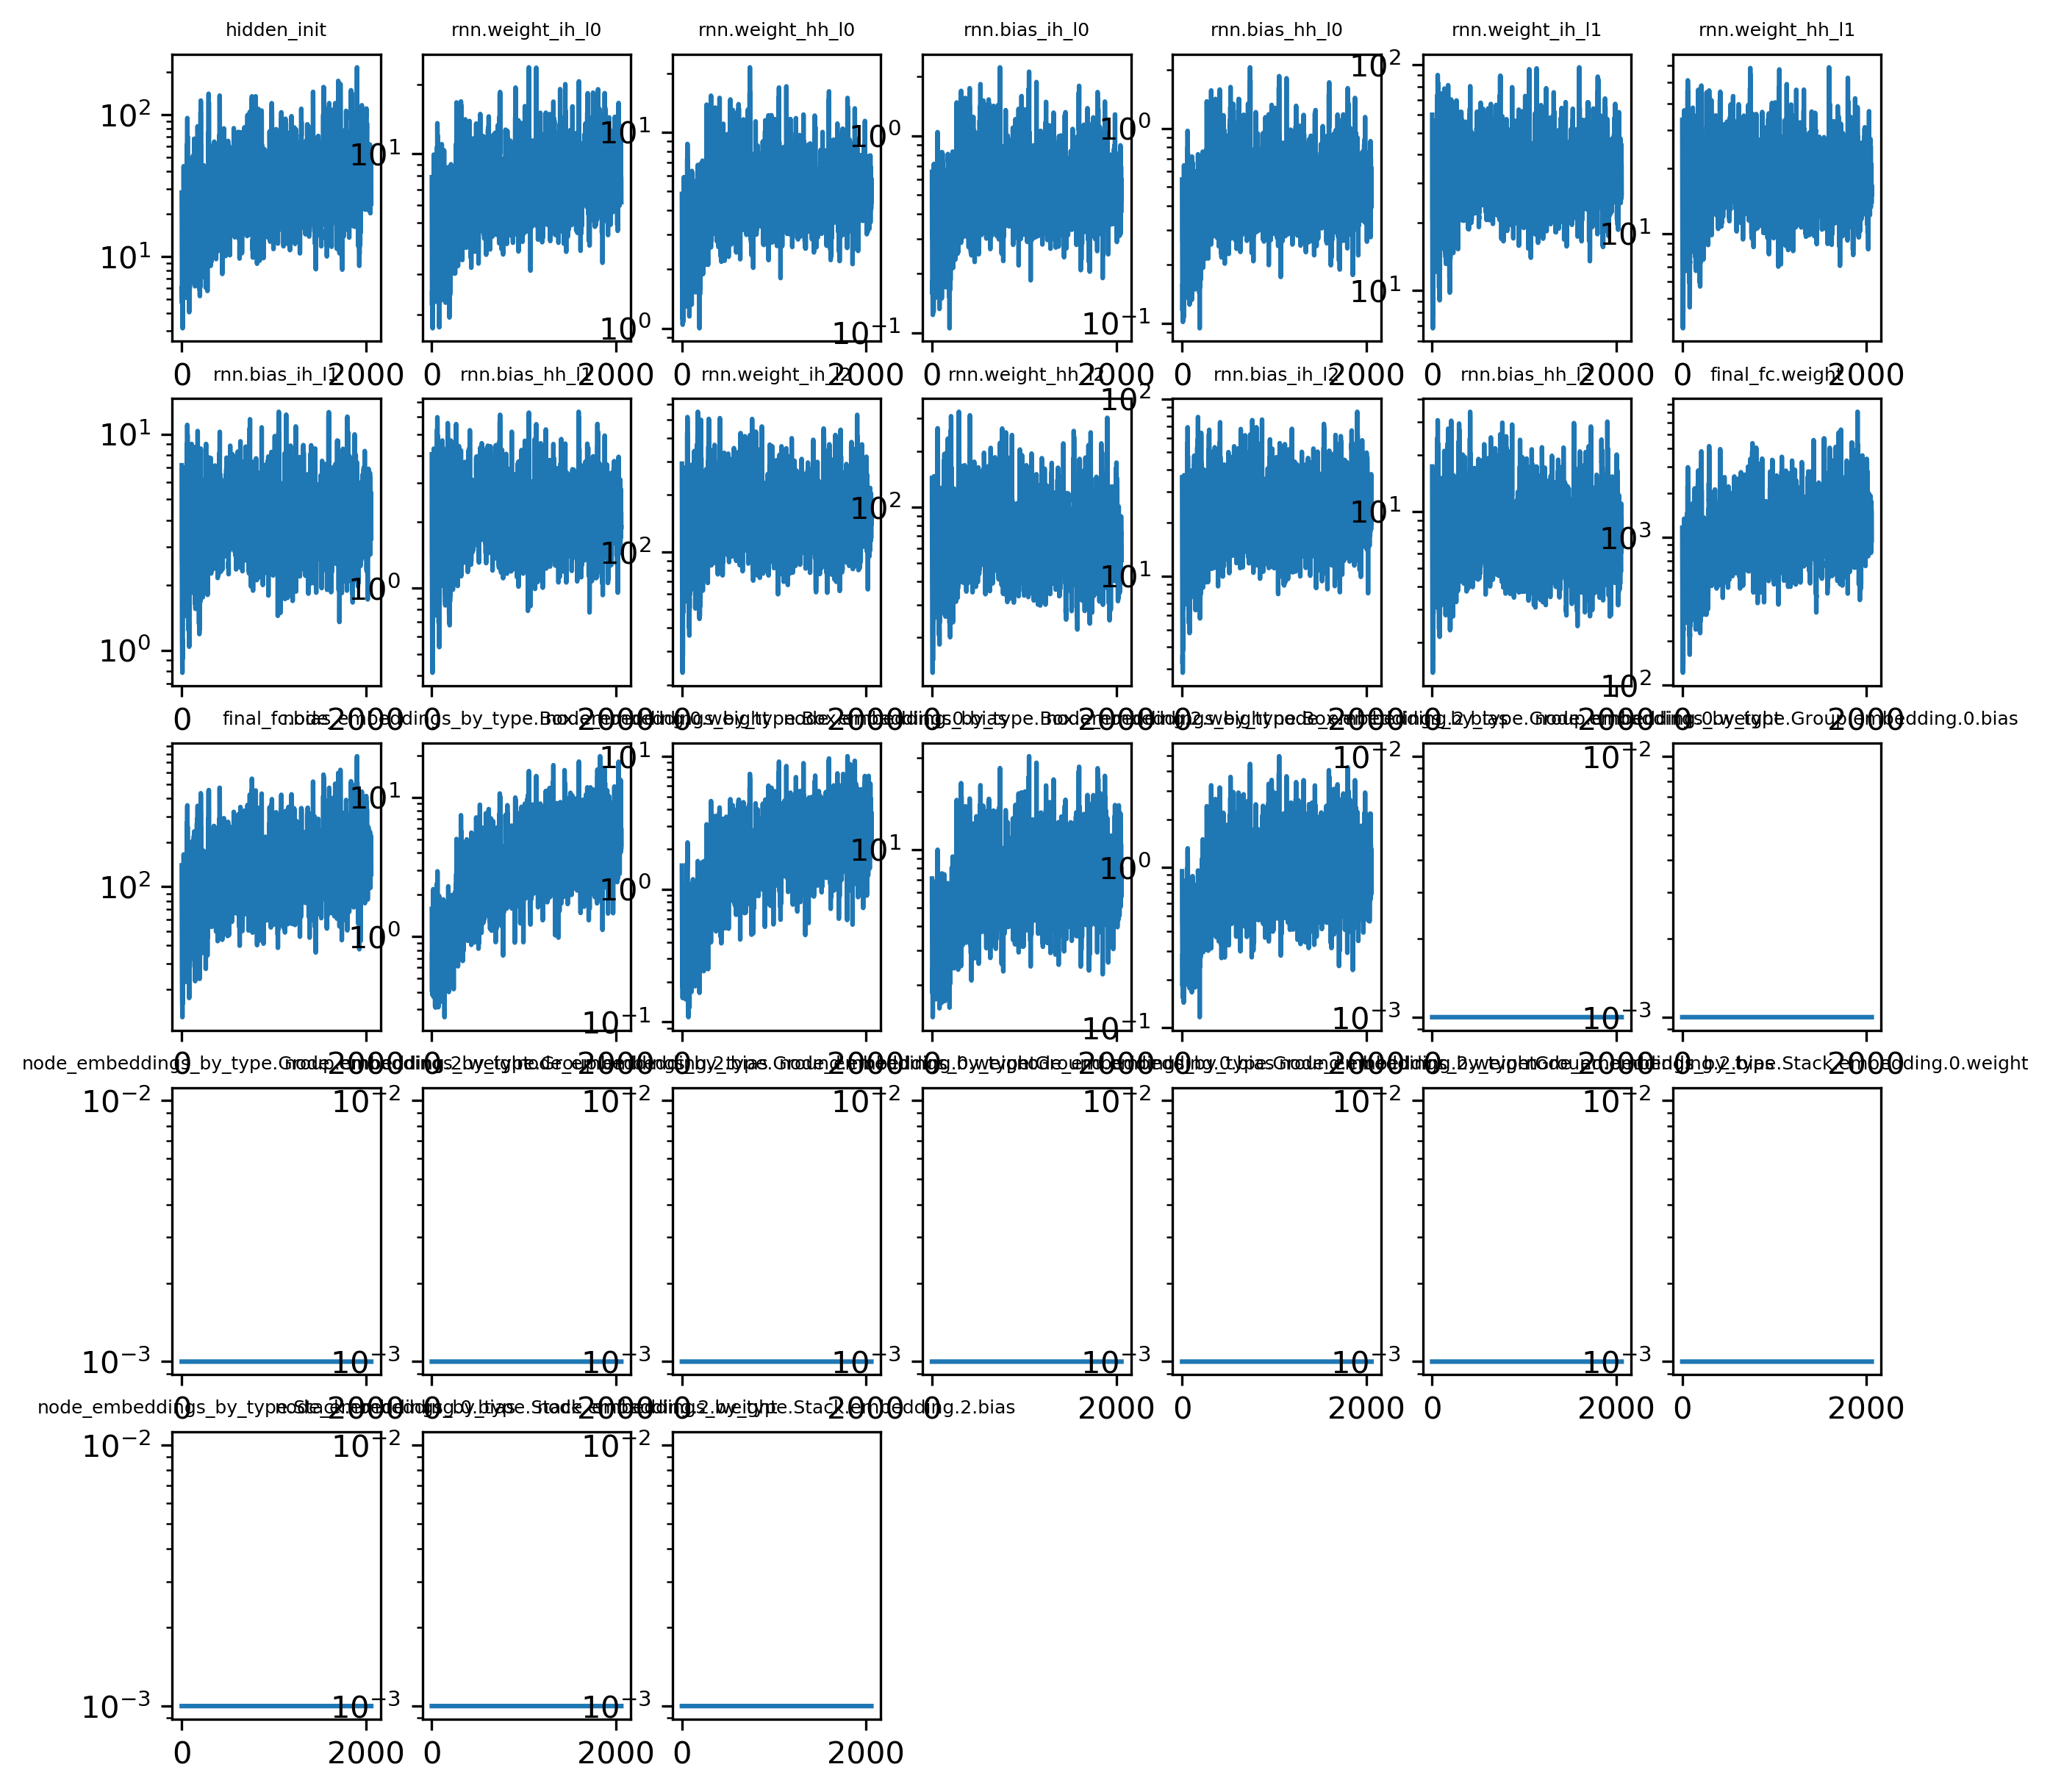

In [20]:
# Draw gradient norm history per param
plt.figure(dpi=300).set_size_inches(10, 10)
n_params = len(all_gradients_history.keys())
for k, (name, history) in enumerate(all_gradients_history.items()):
    ax = plt.subplot(5, n_params // 5 + 1, k+1)
    history = torch.stack(history)
    history = np.linalg.norm(history.reshape(history.shape[0], -1).numpy(), axis=1) + 1E-3
    x = range(history.shape[0])
    ax.plot(x, history)
    plt.yscale("log")
    #ax.fill_between(x, (means-std), (means+std), color='b', alpha=.1)
    plt.title(name, fontsize=6)

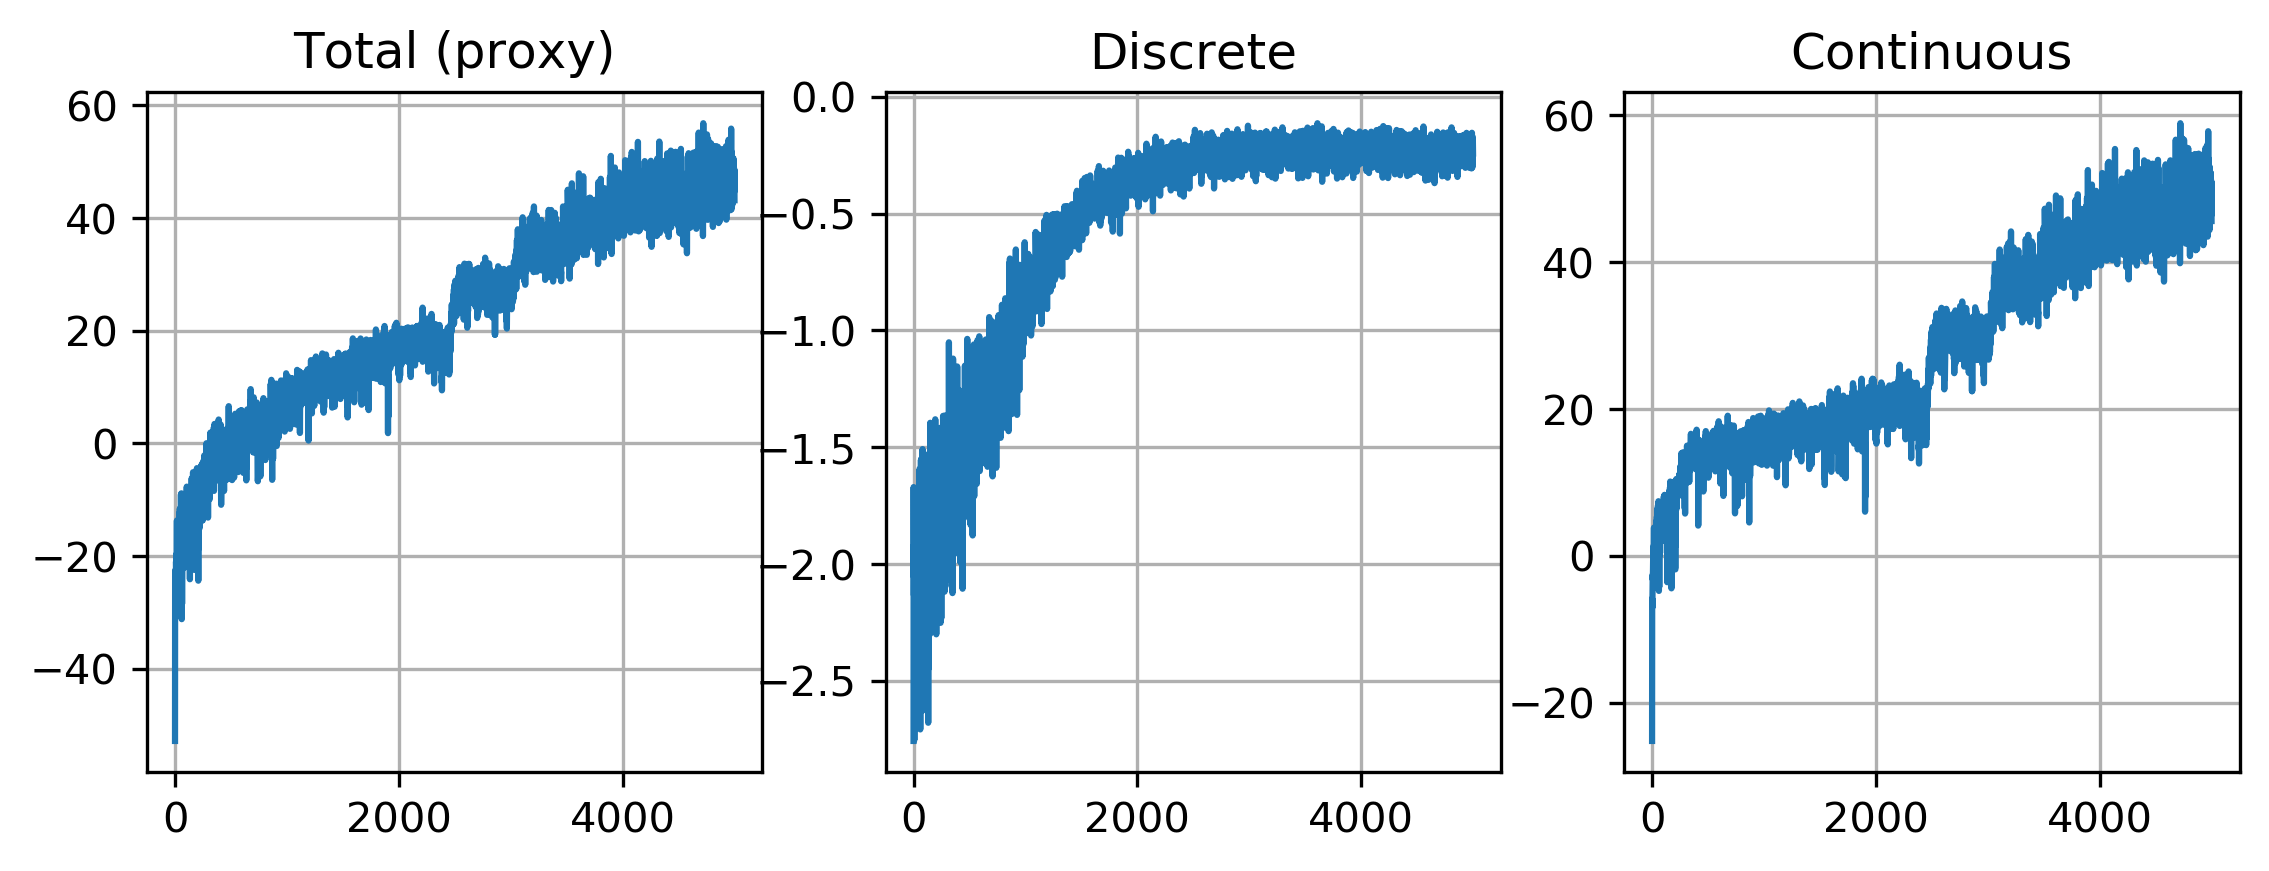

In [28]:
def set_reasonable_bounds(hist, lb, ub):
    low = max(np.min(hist) - 1. , lb)
    high = min(np.max(hist) + 1., ub)
plt.figure(dpi=300).set_size_inches(9, 3)
plt.subplot(1, 3, 1)
plt.title("Total (proxy)")
plt.plot(total_objective_history)
set_reasonable_bounds(total_objective_history, -40, 100.)
plt.grid(True)
plt.subplot(1, 3, 2)
plt.title("Discrete")
plt.plot(discrete_score_history)
set_reasonable_bounds(discrete_score_history, -40., 100.)
plt.grid(True)
plt.subplot(1, 3, 3)
plt.title("Continuous")
plt.plot(continuous_score_history)
plt.grid(True)
set_reasonable_bounds(continuous_score_history, -40., 100)

Entering example  0
Entering example  1
Entering example  2
Entering example  3
Entering example  4
Entering example  5
Entering example  6
Entering example  7
Entering example  0
Entering example  1
Entering example  2
Entering example  3
Entering example  4
Entering example  5
Entering example  6
Entering example  7


Text(0.5, 0.98, 'Draws from encoder/decoder after supervised training, on TEST')

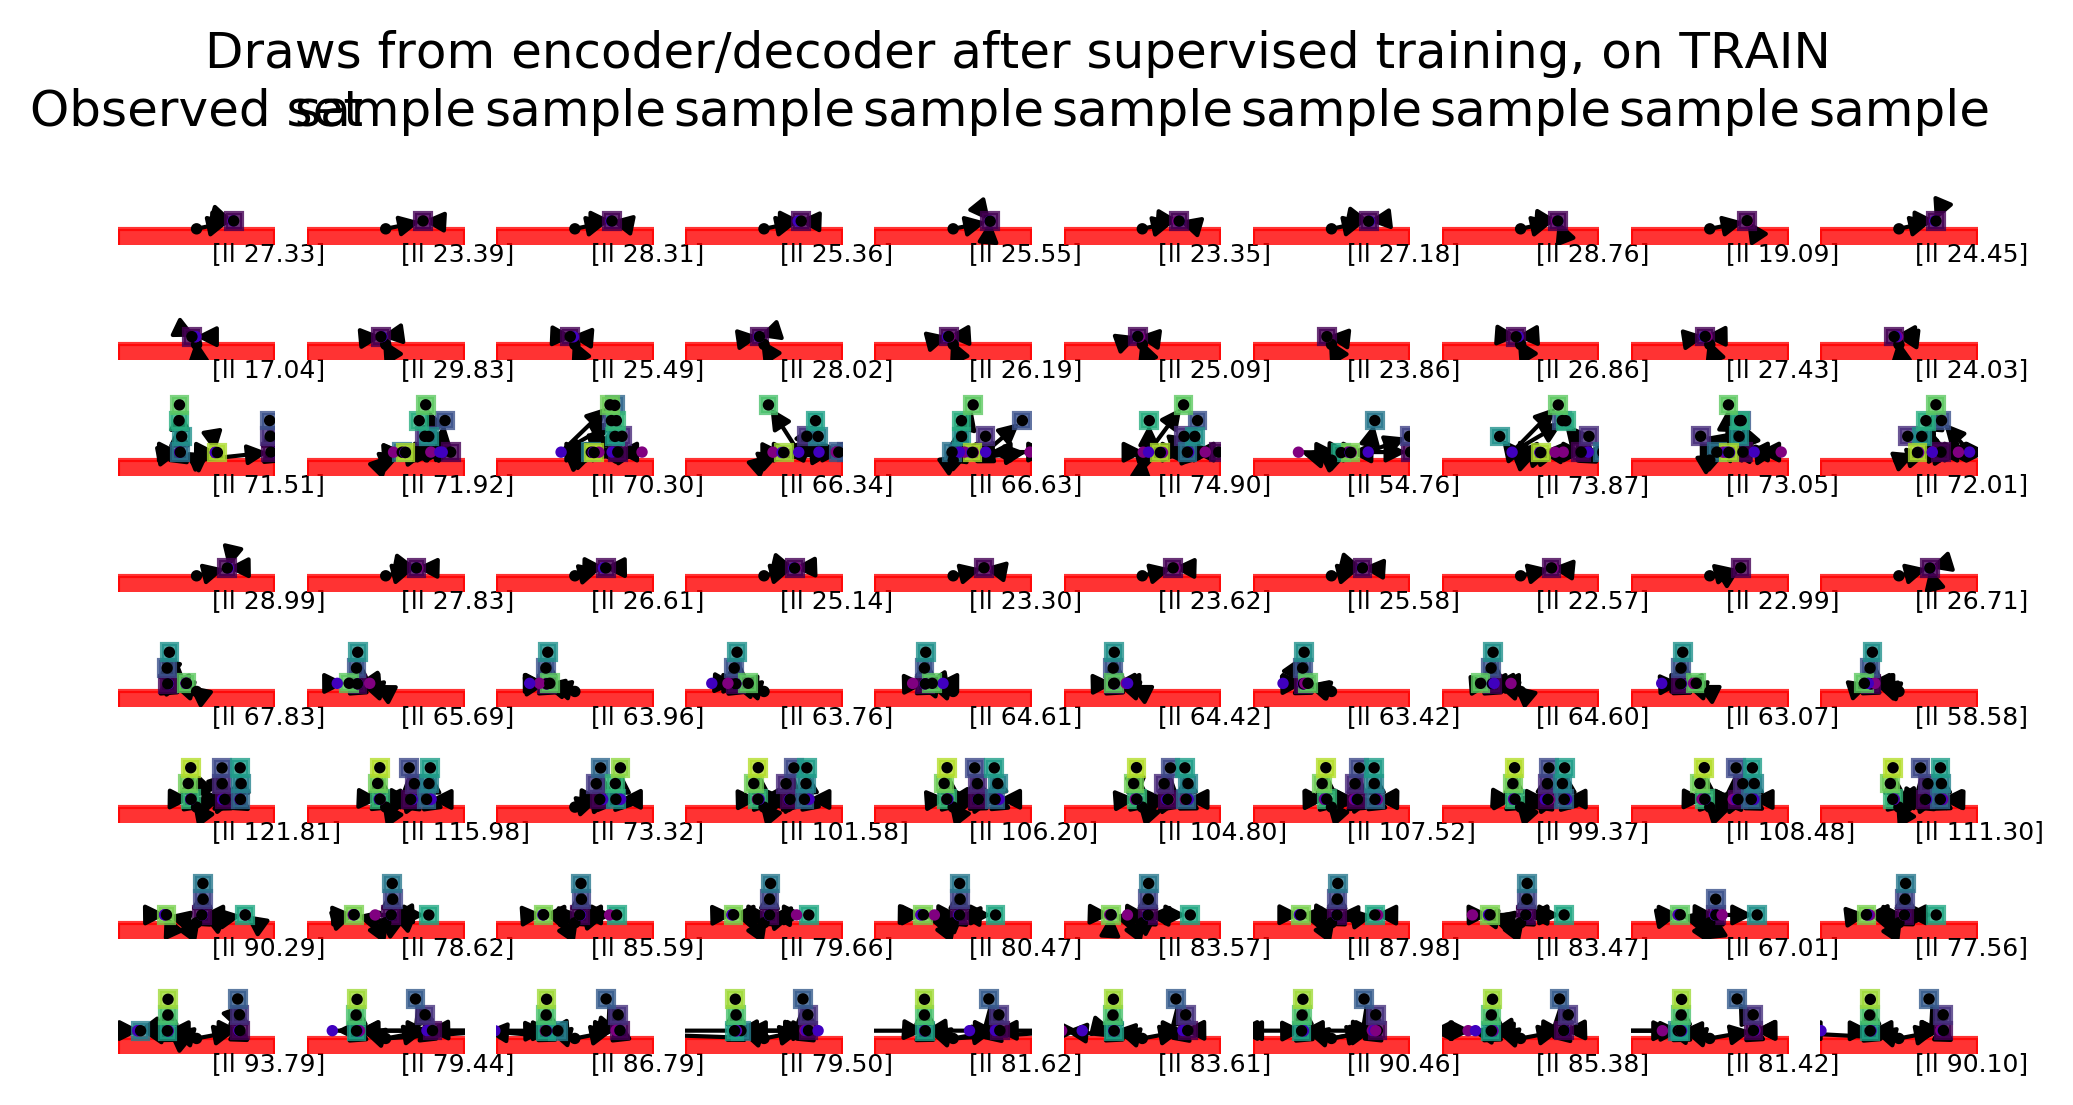

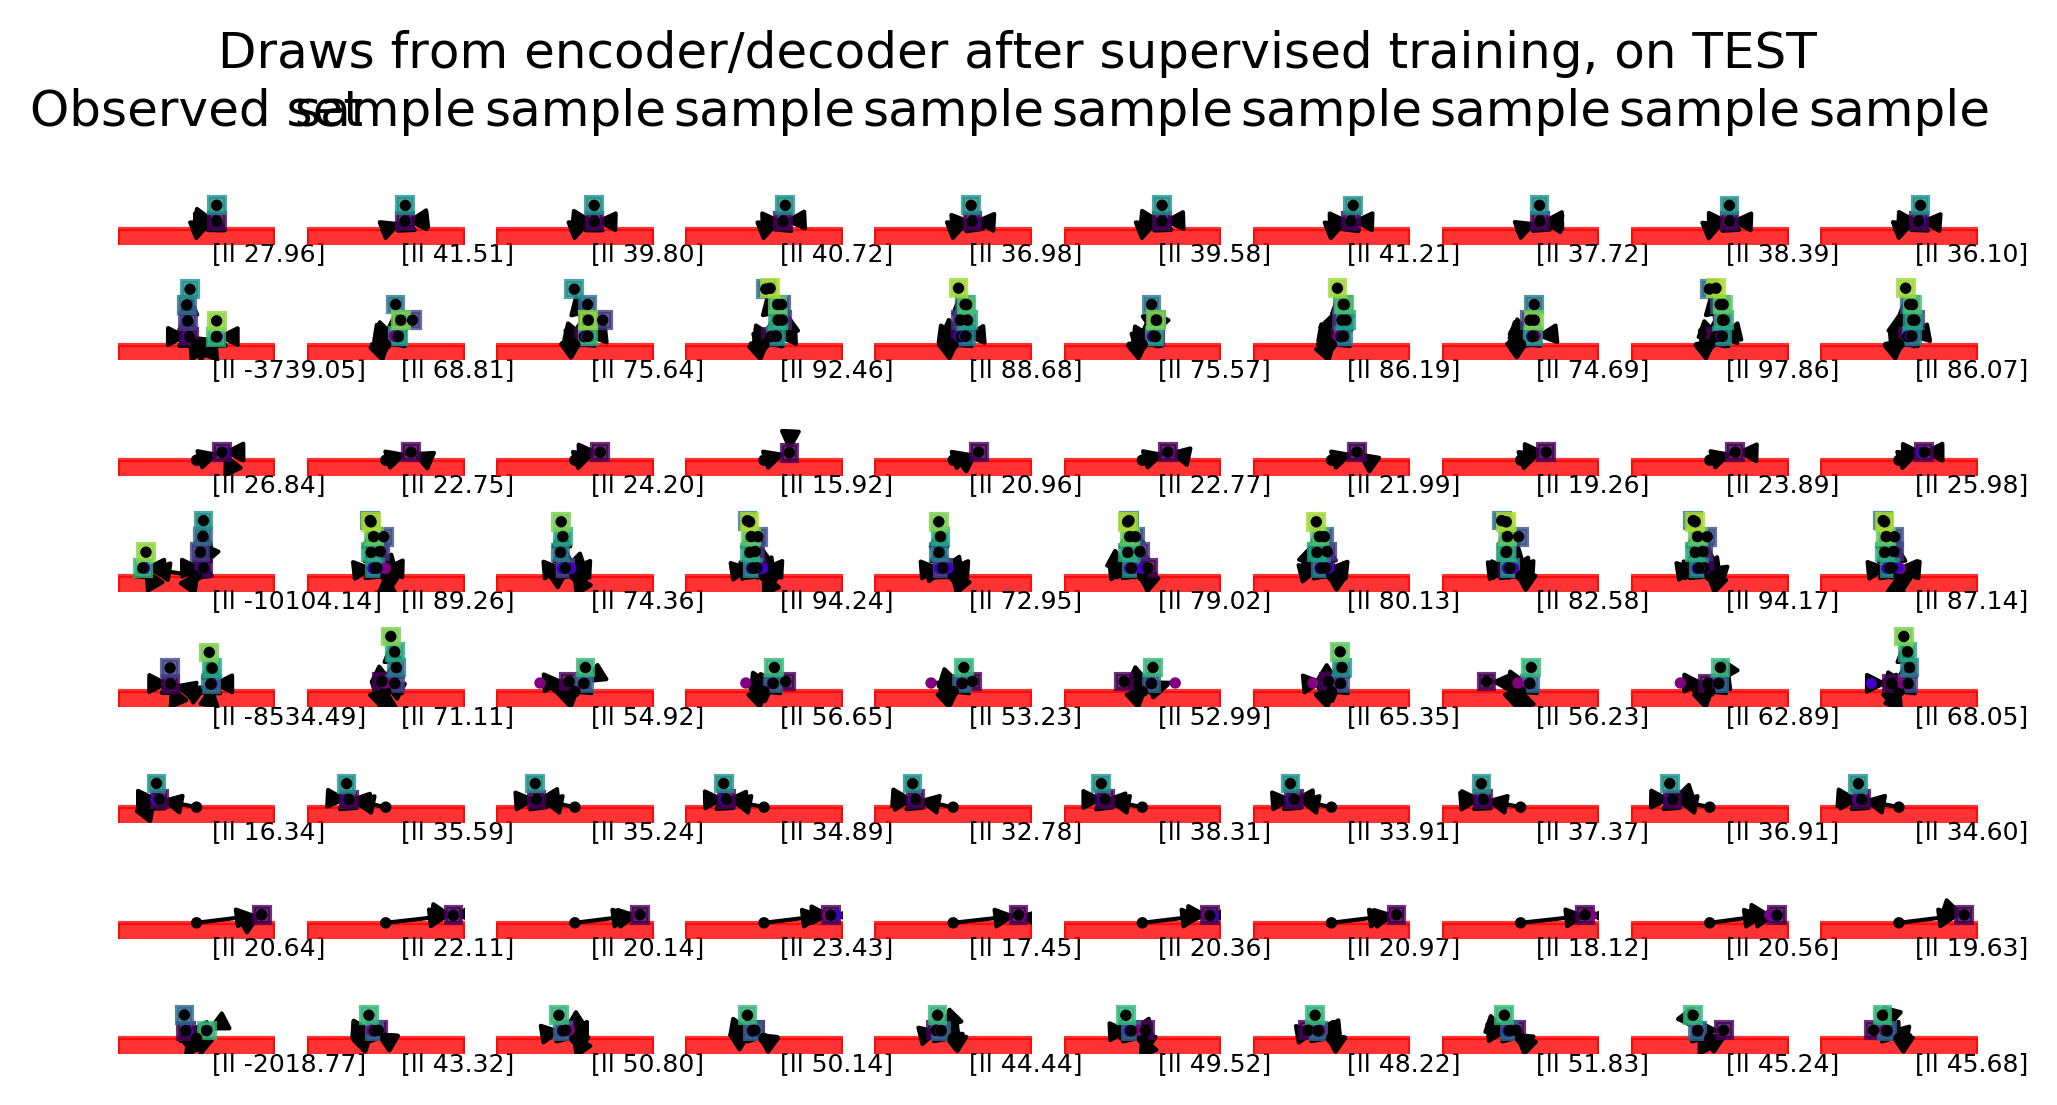

In [29]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 10
    N_height = 8
    torch.random.manual_seed(41)
    
    for i in range(N_height):
        print("Entering example ", i)
        plt.subplot(N_height, N_width, i*N_width + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        
        # Score the test tree under its encoded vector
        density = encoder.score_tree_with_grammar_vector(full_trees[i], x, include_continuous=True)
        plt.text(x=1., y=-2., s="[ll %0.2f]" % density, fontsize=6)
        
        for j in range(1, N_width):
            k = i*N_width + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, _, _ = encoder.sample_tree_from_grammar_vector(x)
            proposal_density = encoder.score_tree_with_grammar_vector(sampled_tree, x, include_continuous=True)
            #box_k = 0
            #for node in sampled_tree.nodes:
            #    if isinstance(node, Box):
            #        node.xy = torch.tensor([0., box_k])
            #        box_k += 1
            #    else:
            #        node.xy = torch.zeros(2)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after supervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after supervised training, on TEST")

In [31]:
# Save output
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime())
)
save_name = "encoder_supervised_gru_%0.04f.torch" % (
    total_objective_history[-1]
)
save_path = os.path.join(save_dir, save_name)
save_encoder_state(save_path)

Saving to path  saved_models/20210609/encoder_supervised_gru_43.1707.torch
Saved model to saved_models/20210609/encoder_supervised_gru_43.1707.torch


In [9]:
# Load output
inference_grammar = FullyParameterizedSuperTreeGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
config = GrammarEncoder.Config(rnn_type="GRU")
encoder = GrammarEncoder(inference_grammar, 512, config=config)
x = encoder(observed_nodes_for_training[0])

if 1:
    # Load encoder from saved run.
    weight_path = "saved_models/20210609/encoder_supervised_gru_43.1707.torch"
    encoder.load_state_dict(torch.load(weight_path))
    encoder.eval()

# Autoencoder Loss Training via Reinforce

Encoding is deterministic, but decoding involves drawing samples of trees from that distribution. I'll notate that whole parameterized enc-decode sampling as drawing $t \sim q_\theta(t^*)$.

To first see if things work, I'd like to directly optimize a loss function $f$ that roughly enforces observed node similarity while being close to the proposal density prior and original grammar prior  $max_\theta E_{t \sim q_\theta(t^*)}\Big[ f(t, t^*) \Big] + log p(\theta)$, for $f(t, t^*) = L(t, t^*) + p(t)$.

So we've unfortunately to use REINFORCE since the decoder is a complex sampling procedure, so our gradient estimate is $E_{t \sim q_\theta(t^*)}\Big[ (f(t, t^*) \nabla_\theta \log q_\theta(t^*) \Big] + log p(\theta) $. (Since I'm operating in pytorch, I'll build a surrogate objective that has that gradient.)


In [ ]:
# Training
from warmup_scheduler import GradualWarmupScheduler


N_EPOCHS = 450
N_ITERS_PER_EPOCH = 25
N_SAMPLES_PER_ENCODING = 4
MIN_LL_SATURATION = -10000

restart_training = True

torch.manual_seed(43)

SETUP_TRAINING = True

def save_encoder_state(save_path):
    print("Saving to path ", save_path)
    try:
        dir_to_make = os.path.split(save_path)[0]
        if dir_to_make is not "":
            os.makedirs(dir_to_make)
    except FileExistsError:
        pass
    torch.save(encoder.state_dict(), save_path)
    print("Saved model to %s" % save_path)
    
checkpoint_save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime()),
    "checkpoints"
)

if SETUP_TRAINING:
    optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=250, factor=0.5)
    mean_sampled_f_history = []
    mean_sampled_score_history = []
    total_objective_history = []
    epoch = 0
    
while epoch < N_EPOCHS:
    total_objective = 0.
    total_sampled_f = 0.
    total_sampled_score = 0.
    total_num_samples = 0
    optimizer.zero_grad()

    if len(mean_sampled_f_history) == 0:
        decaying_avg_baseline = 0.
    elif len(mean_sampled_f_history) < 10:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history))
    else:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history[-10:]))

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        # Calculate contribution of encoding prior (very weak, just keeps values from
        # blowing up.)
        #x_prior_ll = dist.Normal(0., 10.).log_prob(x).sum()
        #total_objective += x_prior_ll * N_SAMPLES_PER_ENCODING
        for sample_k in range(N_SAMPLES_PER_ENCODING):
            sampled_tree, proposal_density_ll, nonreparam_density_ll = encoder.sample_tree_from_grammar_vector(x)
            candidate_nodes = [n for n in sampled_tree.nodes if isinstance(n, TerminalNode)]
            
            # Calculate observation matching score.
            est_ll = (estimate_observation_likelihood(candidate_nodes, observed_nodes, 0.1, detach_second=True) +
                      estimate_observation_likelihood(observed_nodes, candidate_nodes, 0.1, detach_first=True)).sum()
            est_ll = torch.clip(est_ll, min=MIN_LL_SATURATION)
            
            # Calculate grammar prior score.
            grammar_ll = grammar.score(sampled_tree)
            
            # Total value under expectation for evaluation policy gradient.
            total_f = est_ll# + grammar_ll
            
            # Diagnostics
            total_sampled_score += est_ll
            total_sampled_f += total_f
            
            # Surrogate objective for REINFORCE
            total_objective += (total_f.detach() - decaying_avg_baseline) * nonreparam_density_ll + total_f
            total_num_samples += 1

    mean_objective = total_objective / total_num_samples
    mean_sampled_f = total_sampled_f / total_num_samples
    mean_sampled_score = total_sampled_score / total_num_samples
    mean_sampled_f_history.append(mean_sampled_f)
    total_objective_history.append(mean_objective)

    print("%d: Mean sampled loss %.2f, f %.2f, Mean objective %.2f, lr %f"
          % (epoch, mean_sampled_score, mean_sampled_f, mean_objective, 
            optimizer.param_groups[0]['lr']))
    
    if torch.isfinite(mean_objective):
        # Parameter values get gradients calculated but not used;
        # need to retain them to keep pytorch from complaining.
        (-mean_objective).backward(retain_graph=True)
        optimizer.step()
        scheduler.step(mean_objective)
    
    epoch += 1

unsupervised_training_finish_time = time.time()

0: Mean sampled loss -13.34, f -13.34, Mean objective -6.10, lr 0.000100
1: Mean sampled loss -64.09, f -64.09, Mean objective -0.48, lr 0.000100
2: Mean sampled loss -20.55, f -20.55, Mean objective -27.31, lr 0.000100
3: Mean sampled loss -15.05, f -15.05, Mean objective -1.66, lr 0.000100
4: Mean sampled loss -36.07, f -36.07, Mean objective -29.95, lr 0.000100
5: Mean sampled loss -19.12, f -19.12, Mean objective -11.16, lr 0.000100
6: Mean sampled loss -41.72, f -41.72, Mean objective -35.48, lr 0.000100
7: Mean sampled loss -13.05, f -13.05, Mean objective -17.97, lr 0.000100
8: Mean sampled loss -47.27, f -47.27, Mean objective -19.24, lr 0.000100
9: Mean sampled loss -54.86, f -54.86, Mean objective -37.10, lr 0.000100
10: Mean sampled loss -43.58, f -43.58, Mean objective -25.44, lr 0.000100
11: Mean sampled loss -10.26, f -10.26, Mean objective -17.47, lr 0.000100
12: Mean sampled loss -14.59, f -14.59, Mean objective -14.25, lr 0.000100
13: Mean sampled loss -25.06, f -25.06

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(np.array(mean_sampled_f_history) - max(mean_sampled_f_history).item())
plt.title("Mean sampled f, relative to max")      
plt.yscale('symlog')
plt.subplot(1, 2, 2)
plt.plot(np.array(mean_sampled_f_history))
plt.title("Total objective")

In [ ]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(41)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TEST")


In [ ]:
# Save weights
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime(supervised_training_finish_time))
)
try:
    os.makedirs(save_dir)
except FileExistsError:
    pass
save_name = "encoder_unsupervised_%0.04f.torch" % (
    mean_sampled_f_history[-1]
)
save_path = os.path.join(save_dir, save_name)
torch.save(encoder.state_dict(), save_path)
print("Saved model to %s" % save_path)